# Installing the Necessary Libraries or Packages

# import the Data Set

In [1]:
!pip install shap

In [2]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Ai/highest_lambdaZHl_with_CAS.csv'
df = pd.read_csv(file_path)

In [4]:
df = (
    df
    .sort_values('LambdaZHl', ascending=False)
    .drop_duplicates(keep='first')
    .reset_index(drop=True)
)

# Drop the 'Long-acting' column
df = df.drop(columns=['Long-acting'])

# Filter rows where 'CAS' is not NaN and not '56180-94-0'
df = df[df['CAS'].notna() & (df['CAS'] != '56180-94-0')]

# Check the shape of the filtered DataFrame
print("Filtered df Shape:", df.shape)

Filtered df Shape: (351, 8)


In [5]:
df.to_csv('/content/drive/MyDrive/Ai/highest_lambdaZHl_with_CAS_1.csv', index=False)

In [6]:
!pip install -q PubChemPy==1.0.4             # Install PubChemPy library for accessing PubChem data
!pip install -q rdkit-pypi==2022.09.5        # Install rdkit-pypi package, a version of the RDKit cheminformatics toolkit
!pip install -q scikit-optimize==0.10.1      # Install scikit-optimize library for optimization in machine learning

In [7]:
%pip install --upgrade "numpy<1.27" "pybind11>=2.12"

In [8]:
import pandas as pd                            # Data manipulation and analysis library
import numpy as np                             # Numerical operations library
import seaborn as sns                          # Statistical data visualization library
import os
import random
import numpy as np
np.random.seed(42)
random.seed(42)
import pubchempy as pcp                        # PubChem API for accessing chemical information
from pubchempy import get_compounds, Compound  # Functions for working with PubChem data
from collections import Counter                # Container for counting hashable objects

# Molecular Descriptors Calculation
from rdkit import Chem                                 # Toolkit for cheminformatics
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs  # Molecular descriptors and fingerprint generation
from rdkit.DataStructs import ExplicitBitVect          # Data structures for working with molecular descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors   # Calculation of molecular descriptors

# Modeling
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold   # Model selection and evaluation tools
from sklearn import metrics                           # Metrics for evaluating model performance
from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors
from pandas.core.common import random_state           # Setting random state for reproducibility
from sklearn.neighbors import KNeighborsRegressor     # K-Nearest Neighbors regression algorithm development
from sklearn.ensemble import RandomForestRegressor    # Random Forest regression algorithm development
from sklearn.svm import SVR                           # Support Vector Regression algorithm development
from sklearn.metrics import mean_squared_error, r2_score, make_scorer   # Metrics for evaluating regression model performance

# Visualization
import matplotlib.pyplot as plt   # Plotting library
# Setting matplotlib to display plots inline in Jupyter notebooks
%matplotlib inline


In [9]:
df

,CitationNumber,Drug,Analyte,Route,Matrix,Dose,LambdaZHl,CAS
14,9019041,Ivermectin,Ivermectin,Subcutaneous,Plasma,0.63,1128.400000,70288-86-7
25,9015582,Moxidectin,Moxidectin,Cutaneous (topical),Fat,0.50,753.390000,113507-06-5
30,9014635,Doramectin,Doramectin,Intramuscular,Muscle,NaN,672.000000,117704-25-3
34,9015582,Moxidectin,Moxidectin,Subcutaneous,Fat,0.20,568.160000,113507-06-5
36,9016846,Sisapronil,Sisapronil,Subcutaneous,Plasma,2.00,552.000000,856225-89-3
...,...,...,...,...,...,...,...,...
720,9016085,Nalbuphine,Nalbuphine,Intravenous,Plasma,0.40,0.682000,20594-83-6
723,9014783,Acetylsalicylic acid,Acetylsalicylic acid,Intravenous,Plasma,90.00,0.608455,50-78-2
726,9005613,Spectinomycin,Spectinomycin,Intramuscular,Milk,20.00,0.450000,1695-77-8
727,9005613,Spectinomycin,Spectinomycin,Intramuscular,Milk,20.00,0.450000,57-92-1


# Extracting SMILES Codes from PubChem Database

In [10]:
'''
This script automates the retrieval of PubChem CID (Chemical Identifier) and corresponding SMILES
(Simplified Molecular Input Line Entry System) codes from the PubChem database.
The process involves connecting to PubChem, obtaining CID for given CAS
(Chemical Abstracts Service) Registry numbers, and resolving those CIDs to SMILES codes.

'''
# Function to convert CAS numbers to PubChem CIDs and update the DataFrame with PubChemCID column
def cas_to_cid (df):
  df['PubChemCID'] = None

  # Searching PubChem for CID
  for i, CAS in df['CAS'].items():
    try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot of error messages: server is busy

  # Check PubChemCID; If CID is None, run the "While loop" and request PubChem server again to get all Cid
  while df['PubChemCID'].isnull().sum() > 0:
    print (df['PubChemCID'].isnull().sum())
    for i, CAS in df[df['PubChemCID'].isnull()]['CAS'].items():
      try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")
      except Exception as e:
        pass

  return df

# Function for searching and extracting SMILES code with entering CID
def cid_to_smiles (data):
  data['SMILES'] = None

  for i, cid in data['PubChemCID'].items():
    try:
      compound = pcp.Compound.from_cid(cid)
      if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
      else:
        print(f'No results found for PubChemCID {cid}')

    except Exception as e: # a general exception handler
        pass # If an exception is caught, it will ignored, and the code will proceed without raising an error to avoid printing a lot of error messages related to a specific situation ("PUG-REST server is busy").

  # Check SMILES; If SMILES is None, run the "While loop" and request PubChem server again to get all SMILES
  while data['SMILES'].isnull().sum() > 0:
    print (data['SMILES'].isnull().sum())
    for i, cid in data[data['SMILES'].isnull()]['PubChemCID'].items():
     try:
       compound = pcp.Compound.from_cid(cid)
       if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
       else:
        print(f'No results found for PubChemCID {cid}')
     except Exception as e:
       pass

  return data

In [11]:
# Define a function that transforms SMILES string into RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index=smiles, columns=["rdkit_" + str(i) for i in desc_names])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use standard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into Functional-Class Fingerprints (FCFP) (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into molecular ACCess system (MACCS) fingerprints

def cal_MACCS_descr(smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

In [12]:
def run_shap_analysis(best_model_dict, selected_features_dict, feature_matrix_dict):
    for model_name, feature_sets in selected_features_dict.items():
        for feature_type, selected_features in feature_sets.items():
            print(f"\n📊 SHAP Analysis for: {model_name} | Descriptor: {feature_type}")

            X = feature_matrix_dict[feature_type][selected_features]
            model = best_model_dict[model_name][feature_type]

            # Sample for SHAP
            X_sample = shap.utils.sample(X, 100, random_state=42)

            try:
                # RF is natively supported
                if model_name == 'RF':
                    explainer = shap.Explainer(model, X_sample)
                    shap_values = explainer(X_sample)

                # KNN and SVR → KernelExplainer
                elif model_name in ['KNN', 'SVR']:
                    explainer = shap.KernelExplainer(model.predict, X_sample)
                    shap_values = explainer.shap_values(X_sample, nsamples=100)

                # DNN (Keras-based)
                elif model_name == 'DNN':
                    X_tensor = tf.convert_to_tensor(X_sample.values, dtype=tf.float32)
                    explainer = shap.DeepExplainer(model, X_tensor)
                    shap_values = explainer.shap_values(X_tensor)
                    shap_values = shap_values[0]  # unwrap

                else:
                    raise ValueError(f"❗ Model {model_name} not supported.")

                # Plot
                shap.summary_plot(shap_values, X_sample, feature_names=selected_features, max_display=15)

            except Exception as e:
                print(f"❌ SHAP failed for {model_name} | {feature_type} due to: {e}")


In [13]:
df

,CitationNumber,Drug,Analyte,Route,Matrix,Dose,LambdaZHl,CAS
14,9019041,Ivermectin,Ivermectin,Subcutaneous,Plasma,0.63,1128.400000,70288-86-7
25,9015582,Moxidectin,Moxidectin,Cutaneous (topical),Fat,0.50,753.390000,113507-06-5
30,9014635,Doramectin,Doramectin,Intramuscular,Muscle,NaN,672.000000,117704-25-3
34,9015582,Moxidectin,Moxidectin,Subcutaneous,Fat,0.20,568.160000,113507-06-5
36,9016846,Sisapronil,Sisapronil,Subcutaneous,Plasma,2.00,552.000000,856225-89-3
...,...,...,...,...,...,...,...,...
720,9016085,Nalbuphine,Nalbuphine,Intravenous,Plasma,0.40,0.682000,20594-83-6
723,9014783,Acetylsalicylic acid,Acetylsalicylic acid,Intravenous,Plasma,90.00,0.608455,50-78-2
726,9005613,Spectinomycin,Spectinomycin,Intramuscular,Milk,20.00,0.450000,1695-77-8
727,9005613,Spectinomycin,Spectinomycin,Intramuscular,Milk,20.00,0.450000,57-92-1


In [14]:
df_with_cids = cas_to_cid(df)
df_with_smiles = cid_to_smiles(df_with_cids)

In [15]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_with_smiles['SMILES']).drop(['rdkit_BCUT2D_MWHI', 'rdkit_BCUT2D_MWLOW', 'rdkit_BCUT2D_CHGHI', 'rdkit_BCUT2D_CHGLO', 'rdkit_BCUT2D_LOGPHI', 'rdkit_BCUT2D_LOGPLOW', 'rdkit_BCUT2D_MRHI', 'rdkit_BCUT2D_MRLOW'],axis=1)
rdkit_descrs

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(C(C=CC=C4COC5C4(C(C=C(C5O)C)C(=O)O3)O)C)OC6CC(C(C(O6)C)OC7CC(C(C(O7)C)O)OC)OC)C)C,16.482562,-6.946897,16.482562,2.859322,0.203525,875.106,800.514,874.507857,350,0,...,0,0,0,0,0,0,0,0,0,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,16.106224,-6.305472,16.106224,2.616376,0.228689,639.830,586.406,639.377118,254,0,...,0,0,0,0,0,0,0,0,0,0
CC1C=CC=C2COC3C2(C(C=C(C3O)C)C(=O)OC4CC(CC=C(C1OC5CC(C(C(O5)C)OC6CC(C(C(O6)C)O)OC)OC)C)OC7(C4)C=CC(C(O7)C8CCCCC8)C)O,16.520087,-6.909168,16.520087,2.830073,0.203663,899.128,824.536,898.507857,358,0,...,0,0,0,0,0,0,0,0,0,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,16.106224,-6.305472,16.106224,2.616376,0.228689,639.830,586.406,639.377118,254,0,...,0,0,0,0,0,0,0,0,0,0
C1C(C1(F)F)(C2=C(N(N=C2C#N)C3=C(C=C(C=C3Cl)C(F)(F)F)Cl)N)C(F)(F)F,14.433828,-6.139761,14.433828,0.159963,0.597052,465.131,459.083,463.984177,156,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1CC(C1)CN2CCC34C5C(CCC3(C2CC6=C4C(=C(C=C6)O)O5)O)O,9.948376,-4.903849,9.948376,1.073006,0.751486,357.450,330.234,357.194008,140,0,...,0,0,0,0,0,0,0,0,0,0
CC(=O)OC1=CC=CC=C1C(=O)O,11.412469,-3.195837,11.412469,0.824923,0.550122,180.159,172.095,180.042259,68,0,...,0,0,0,0,0,0,0,0,0,0
CC1CC(=O)C2(C(O1)OC3C(C(C(C(C3O2)NC)O)NC)O)O,13.677171,-4.913183,13.677171,1.221082,0.360820,332.353,308.161,332.158351,132,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Calculating ECFP6 fingerprints
ECFP6_descrs = cal_ECFP6_descr(df_with_smiles['SMILES'])
ECFP6_descrs

,ECFP6_Bit_0,ECFP6_Bit_1,ECFP6_Bit_2,ECFP6_Bit_3,ECFP6_Bit_4,ECFP6_Bit_5,ECFP6_Bit_6,ECFP6_Bit_7,ECFP6_Bit_8,ECFP6_Bit_9,...,ECFP6_Bit_1014,ECFP6_Bit_1015,ECFP6_Bit_1016,ECFP6_Bit_1017,ECFP6_Bit_1018,ECFP6_Bit_1019,ECFP6_Bit_1020,ECFP6_Bit_1021,ECFP6_Bit_1022,ECFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(C(C=CC=C4COC5C4(C(C=C(C5O)C)C(=O)O3)O)C)OC6CC(C(C(O6)C)OC7CC(C(C(O7)C)O)OC)OC)C)C,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
CC1C=CC=C2COC3C2(C(C=C(C3O)C)C(=O)OC4CC(CC=C(C1OC5CC(C(C(O5)C)OC6CC(C(C(O6)C)O)OC)OC)C)OC7(C4)C=CC(C(O7)C8CCCCC8)C)O,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
C1C(C1(F)F)(C2=C(N(N=C2C#N)C3=C(C=C(C=C3Cl)C(F)(F)F)Cl)N)C(F)(F)F,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1CC(C1)CN2CCC34C5C(CCC3(C2CC6=C4C(=C(C=C6)O)O5)O)O,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CC(=O)OC1=CC=CC=C1C(=O)O,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CC1CC(=O)C2(C(O1)OC3C(C(C(C(C3O2)NC)O)NC)O)O,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
# Calculating FCFP6 fingerprints
FCFP6_descrs = cal_FCFP6_descr(df_with_smiles['SMILES'])
FCFP6_descrs

,FCFP6_Bit_0,FCFP6_Bit_1,FCFP6_Bit_2,FCFP6_Bit_3,FCFP6_Bit_4,FCFP6_Bit_5,FCFP6_Bit_6,FCFP6_Bit_7,FCFP6_Bit_8,FCFP6_Bit_9,...,FCFP6_Bit_1014,FCFP6_Bit_1015,FCFP6_Bit_1016,FCFP6_Bit_1017,FCFP6_Bit_1018,FCFP6_Bit_1019,FCFP6_Bit_1020,FCFP6_Bit_1021,FCFP6_Bit_1022,FCFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(C(C=CC=C4COC5C4(C(C=C(C5O)C)C(=O)O3)O)C)OC6CC(C(C(O6)C)OC7CC(C(C(O7)C)O)OC)OC)C)C,1,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,1,1,0,0,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,1,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
CC1C=CC=C2COC3C2(C(C=C(C3O)C)C(=O)OC4CC(CC=C(C1OC5CC(C(C(O5)C)OC6CC(C(C(O6)C)O)OC)OC)C)OC7(C4)C=CC(C(O7)C8CCCCC8)C)O,1,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,1,1,0,0,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,1,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
C1C(C1(F)F)(C2=C(N(N=C2C#N)C3=C(C=C(C=C3Cl)C(F)(F)F)Cl)N)C(F)(F)F,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1CC(C1)CN2CCC34C5C(CCC3(C2CC6=C4C(=C(C=C6)O)O5)O)O,1,0,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CC(=O)OC1=CC=CC=C1C(=O)O,1,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CC1CC(=O)C2(C(O1)OC3C(C(C(C(C3O2)NC)O)NC)O)O,1,0,1,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [18]:
# Calculating MACCS fingerprints
MACCS_descrs = cal_MACCS_descr(df_with_smiles['SMILES'])
MACCS_descrs

,MACCS_Bit_0,MACCS_Bit_1,MACCS_Bit_2,MACCS_Bit_3,MACCS_Bit_4,MACCS_Bit_5,MACCS_Bit_6,MACCS_Bit_7,MACCS_Bit_8,MACCS_Bit_9,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(C(C=CC=C4COC5C4(C(C=C(C5O)C)C(=O)O3)O)C)OC6CC(C(C(O6)C)OC7CC(C(C(O7)C)O)OC)OC)C)C,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,0
CC1C=CC=C2COC3C2(C(C=C(C3O)C)C(=O)OC4CC(CC=C(C1OC5CC(C(C(O5)C)OC6CC(C(C(O6)C)O)OC)OC)C)OC7(C4)C=CC(C(O7)C8CCCCC8)C)O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)C)C)OC(=O)C4C=C(C(C5C4(C(=CC=C1)CO5)O)O)C)C,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,0
C1C(C1(F)F)(C2=C(N(N=C2C#N)C3=C(C=C(C=C3Cl)C(F)(F)F)Cl)N)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1CC(C1)CN2CCC34C5C(CCC3(C2CC6=C4C(=C(C=C6)O)O5)O)O,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
CC(=O)OC1=CC=CC=C1C(=O)O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
CC1CC(=O)C2(C(O1)OC3C(C(C(C(C3O2)NC)O)NC)O)O,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0


In [19]:
# Applying feature scaling for RDKit descriptors
scaler = MinMaxScaler()
X_rdkit_descrs = rdkit_descrs
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit_descrs.columns.values.tolist())
X_rdkit_descrs_scal

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
0,0.933878,0.216638,0.933878,0.783358,0.192663,0.724427,0.722953,0.724366,0.723301,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.890834,0.305791,0.890834,0.716799,0.221380,0.493160,0.491384,0.493102,0.490291,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.938170,0.221882,0.938170,0.775344,0.192822,0.748040,0.748934,0.747971,0.742718,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.890834,0.305791,0.890834,0.716799,0.221380,0.493160,0.491384,0.493102,0.490291,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.699554,0.328823,0.699554,0.043824,0.641745,0.321438,0.353677,0.320593,0.252427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.186531,0.500605,0.186531,0.293967,0.817981,0.215591,0.214320,0.215559,0.213592,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,0.353987,0.738006,0.353987,0.226001,0.588190,0.041321,0.043285,0.041320,0.038835,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
348,0.613011,0.499308,0.613011,0.334535,0.372165,0.190922,0.190447,0.190935,0.194175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,0.637812,0.347493,0.637812,0.276088,0.038286,0.435903,0.443646,0.435946,0.432039,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Convert "Route", and "Matrix" to binary values using one-hot encoding
encoded_columns = pd.get_dummies(df[['Route', 'Matrix']])
encoded_columns = encoded_columns.astype(int)

# Display the first few rows to verify the changes
encoded_columns.head()

,Route_Bronchial fluid,Route_Cutaneous (topical),Route_IV (Regional Limb Perfusion),Route_Intra-Arterial,Route_Intramammary,Route_Intramuscular,Route_Intraruminal,Route_Intrauterine,Route_Intravenous,Route_Oral,...,Matrix_Liver,Matrix_Lungs,Matrix_Milk,Matrix_Muscle,Matrix_Plasma,Matrix_Serum,Matrix_Siiral Colon Untrafiltrate,Matrix_Skin,Matrix_Sunovial fluid,Matrix_Transudate
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
25,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Build Machine Learning Modeling Pipeline with Feature Selection

In [21]:
!pip install -U scikit-learn
!pip install -U scikit-optimize
!pip install scikit-learn==0.24.2
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-optimize
    Found existing installation: scikit-optimize 0.10.1
    Uninstalling scikit-optimize-0.10.1:
      Successfully uninstalled scikit-optimize-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 48.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [22]:
# feature selection
# Correlation Feature Selection (Regression input data): https://machinelearningmastery.com/feature-selection-for-regression-data/
from sklearn.feature_selection import SelectKBest             # A feature selection method which selects the top k features based on a specified scoring function (f_regression)
from sklearn.feature_selection import f_regression            # A scoring function commonly used for regression tasks. It computes the correlation between each feature and the target variable (using F-values and p-values).

# model
import sklearn                                                # Scikit-learn, a machine learning library
from sklearn.neighbors import KNeighborsRegressor             # K-Nearest Neighbors (KNN) regression algorithm
from sklearn.ensemble import RandomForestRegressor            # Random Forest (RF) regression algorithm
from sklearn.svm import SVR                                   # Support Vector Regression (SVR) algorithm
from sklearn.model_selection import train_test_split          # Function for splitting data into training and testing sets

# model performance
from sklearn.preprocessing import MinMaxScaler                # Feature scaling
from sklearn.model_selection import KFold                     # K-Fold cross-validation
from sklearn.metrics import r2_score                          # R-squared score metric for regression
from sklearn.metrics import mean_squared_error as mse         # Mean Squared Error metric
import warnings                                               # Warning control
warnings.filterwarnings("ignore")                             # Ignore warning messages

from skopt import BayesSearchCV                               # Bayesian optimization for hyperparameter tuning
from skopt.callbacks import DeadlineStopper, DeltaYStopper    # Callbacks for stopping optimization
from skopt.space import Real, Categorical, Integer            # Search space for hyperparameter tuning
from sklearn.model_selection import RepeatedStratifiedKFold   # Repeated Stratified K-Fold cross-validation

In [23]:
# KNN parameters distribution for hyperparameter tuning
knn_parm_search = {
    'n_neighbors': [1, 10, 50],         # Number of neighbors to consider
    'weights': ['uniform', 'distance']  # Weighting scheme for neighbors: 'uniform' or 'distance'
}

# RandomForest parameter distribution for hyperparameter tuning
rf_parm_search = {
     'bootstrap': [True, False],        # Whether to bootstrap samples
     'max_depth': [50, 150, 200],       # Maximum depth of the trees
     'max_features': [None, 'sqrt', 'log2'],  # Maximum number of features to consider for splitting
     'min_samples_leaf': [5, 10, 15],   # Minimum number of samples required to be a leaf node
     'min_samples_split': [5, 10, 150], # Minimum number of samples required to split an internal node
     'max_leaf_nodes': [50, 150, 200],  # Maximum number of leaf nodes
     'n_estimators': [50, 150, 200],    # Number of trees in the forest
}

# SVR parameters distribution for hyperparameter tuning
svr_parm_search = {
     'C': [1, 50, 100],                 # Regularization parameter
     "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type for the algorithm
     'gamma': ['scale', 'auto'],        # Kernel coefficient
}


In [24]:
models = {
    'KNN': (KNeighborsRegressor(), knn_parm_search),
    'RF': (RandomForestRegressor(), rf_parm_search),
    'SVR': (SVR(), svr_parm_search)
}

In [25]:
# Reset indices for encoded_columns and descriptor matrices
encoded_columns = encoded_columns.reset_index(drop=True)
X_rdkit_descrs_scal = X_rdkit_descrs_scal.reset_index(drop=True)
ECFP6_descrs = ECFP6_descrs.reset_index(drop=True)
FCFP6_descrs = FCFP6_descrs.reset_index(drop=True)
MACCS_descrs = MACCS_descrs.reset_index(drop=True)

# Concatenate each descriptor matrix with encoded_columns
X_rdkit = pd.concat([encoded_columns, X_rdkit_descrs_scal], axis=1)
print("Shape of X_rdkit:", X_rdkit.shape)

X_ECFP6 = pd.concat([encoded_columns, ECFP6_descrs], axis=1)
print("Shape of X_ECFP6:", X_ECFP6.shape)

X_FCFP6 = pd.concat([encoded_columns, FCFP6_descrs], axis=1)
print("Shape of X_FCFP6:", X_FCFP6.shape)

X_MACCS = pd.concat([encoded_columns, MACCS_descrs], axis=1)
print("Shape of X_MACCS:", X_MACCS.shape)

# Combine all descriptor matrices into X_All_descrs
X_All_descrs = pd.concat(
    [encoded_columns, X_rdkit_descrs_scal, ECFP6_descrs, FCFP6_descrs, MACCS_descrs],
    axis=1
)
print("Shape of X_All_descrs:", X_All_descrs.shape)

Shape of X_rdkit: (351, 233)
Shape of X_ECFP6: (351, 1057)
Shape of X_FCFP6: (351, 1057)
Shape of X_MACCS: (351, 200)
Shape of X_All_descrs: (351, 2448)


In [26]:
feature_matrix_dict = {
    'X_rdkit': X_rdkit,
    'X_ECFP6': X_ECFP6,
    'X_FCFP6': X_FCFP6,
    'X_MACCS': X_MACCS,
    'X_All_descrs': X_All_descrs
}

In [27]:
y = df['LambdaZHl']  # Half-life
feature_types = ['X_rdkit', 'X_ECFP6', 'X_FCFP6', 'X_MACCS', 'X_All_descrs']  # five types of descriptors

In [28]:
import pandas as pd
from math import sqrt

# Convert y to a numeric type, forcing non-convertible values to NaN (if any)
y = pd.to_numeric(y, errors='coerce')

# Check for NaNs and handle them if necessary
if y.isnull().any():
    print("NaN values found in y after conversion. Handling NaNs...")
    # You can fill NaNs with a value or drop them depending on your requirement
    y.fillna(method='ffill', inplace=True)  # Example: forward fill

In [29]:
# Define the number of features to select
k_best_features = 15

# Function to perform feature selection and return selected features
def select_features(X_train, y_train):
    # Exclude specified columns
    X_train_descriptors = X_train

    selector = SelectKBest(score_func=f_regression, k=k_best_features)
    X_train_selected = selector.fit_transform(X_train_descriptors, y_train)
    selected_feature_indices = selector.get_support(indices=True)
    selected_features = X_train_descriptors.columns[selected_feature_indices].tolist()

    # Print selected features
    print("Selected Features:", selected_features)

    return selector, X_train_selected, selected_features

# Hyperparameter tuning for three algorithms: KNN, RF, and SVR
def tuning_hyper(X, y, model_name):
    model, parm_search = models[model_name]

    bs = BayesSearchCV(
        estimator=model,
        search_spaces=parm_search,
        cv=5,
        n_iter=80,
        n_jobs=-1,
        scoring="r2",
        return_train_score=True,
        random_state=2
    )

    bs.fit(X, y)

    best_model = bs.best_estimator_
    best_params = bs.best_params_
    y_hat_train = best_model.predict(X)
    y_obs = y.tolist()

    r2_kfolds = cross_val_score(best_model, X, y, cv=5, n_jobs=-1, scoring='r2')
    rmse_kfolds = cross_val_score(best_model, X, y, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
    r2_train = r2_score(y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(y, y_hat_train))

    results = {'cv_r2_mean': [], 'cv_r2_sd': [],
               'cv_rmse_mean': [], 'cv_rmse_sd': [],
               'r2_train': [], 'rmse_train': []}

    results['cv_r2_mean'].append(r2_kfolds.mean())
    results['cv_r2_sd'].append(r2_kfolds.std())
    results['cv_rmse_mean'].append(-1 * rmse_kfolds.mean())
    results['cv_rmse_sd'].append(rmse_kfolds.std())
    results['r2_train'].append(r2_train)
    results['rmse_train'].append(rmse_train)

    return best_model, best_params, results

feature_types = ['X_rdkit', 'X_ECFP6', 'X_FCFP6', 'X_MACCS', 'X_All_descrs']  # five types of descriptors
species_columns = ['Cattle']

In [30]:
# Create dictionaries to store selected features, best models, and results for each model and descriptor combination
selected_features_dict = {model_name: {} for model_name in models.keys()}
best_model_dict = {model_name: {} for model_name in models.keys()}
results_dict = {model_name: {} for model_name in models.keys()}

# Perform feature selection, hyperparameter tuning, and model evaluation for each model and descriptor combination
for model_name, (model, _) in models.items():
    for feature_type, X in zip(feature_types, [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All_descrs]):
        print(f"========== Model: {model_name}, Feature Type: {feature_type} ==========")

        # Split the current X data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9)

        # Print the shape of the training and test sets
        print(f"Training Set Shape - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test Set Shape - X: {X_test.shape}, y: {y_test.shape}")

        # Perform feature selection on training data
        selector, X_train_selected, selected_features = select_features(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Store selected features in the dictionary
        selected_features_dict[model_name][feature_type] = selected_features

        # Call tuning_hyper with selected features and training data
        best_model, best_params, results = tuning_hyper(X=X_train_selected, y=y_train, model_name=model_name)

        # Store best model and results in the dictionaries
        best_model_dict[model_name][feature_type] = best_model
        results_dict[model_name][feature_type] = results

        print("Best Params:", best_params)
        print("Results:", results)
        print("\n")

        # Evaluate the best model on the test data
        y_hat_test = best_model.predict(X_test_selected)
        r2_test = r2_score(y_test, y_hat_test)
        rmse_test = sqrt(mean_squared_error(y_test, y_hat_test))

        print("Test Results:")
        print("R2 Test:", r2_test)
        print("RMSE Test:", rmse_test)
        print("\n")

# Print the selected features for each model and descriptor combination
for model_name, features_dict in selected_features_dict.items():
    print(f"Selected Features for Model: {model_name}")
    for feature_type, selected_features in features_dict.items():
        print(f"Feature Type: {feature_type}, Selected Features: {selected_features}")
    print("\n")

========== Model: KNN, Feature Type: X_rdkit ==========
Training Set Shape - X: (235, 233), y: (235,)
Test Set Shape - X: (116, 233), y: (116,)
Selected Features: ['rdkit_MinAbsEStateIndex', 'rdkit_BertzCT', 'rdkit_Chi1n', 'rdkit_Chi2n', 'rdkit_Chi2v', 'rdkit_Chi3n', 'rdkit_Chi4n', 'rdkit_PEOE_VSA6', 'rdkit_SMR_VSA5', 'rdkit_SlogP_VSA5', 'rdkit_EState_VSA10', 'rdkit_VSA_EState1', 'rdkit_NumAliphaticRings', 'rdkit_fr_allylic_oxid', 'rdkit_fr_ester']
Best Params: OrderedDict([('n_neighbors', 10), ('weights', 'distance')])
Results: {'cv_r2_mean': [0.35866949908041423], 'cv_r2_sd': [0.11831502041925877], 'cv_rmse_mean': [100.334628828174], 'cv_rmse_sd': [36.392489015254455], 'r2_train': [0.5927998215978798], 'rmse_train': [85.61962674896948]}


Test Results:
R2 Test: 0.221001069773622
RMSE Test: 103.2435547391614


========== Model: KNN, Feature Type: X_ECFP6 ==========
Training Set Shape - X: (235, 1057), y: (235,)
Test Set Shape - X: (116, 1057), y: (116,)
Selected Features: ['ECFP6_Bit_

In [31]:
#Saving selected_features_dict to CSV
import pandas as pd

# Flatten selected_features_dict to convert it into a DataFrame
flattened_selected_features = {
    (model_name, feature_type): selected_features
    for model_name, features_dict in selected_features_dict.items()
    for feature_type, selected_features in features_dict.items()
}

# Convert to DataFrame
df_selected_features = pd.DataFrame.from_dict(flattened_selected_features, orient='index').reset_index()
df_selected_features.columns = ['Model', 'Feature_Type'] + [f'Feature_{i+1}' for i in range(df_selected_features.shape[1] - 2)]

# Save to CSV
df_selected_features.to_csv('/content/drive/MyDrive/Ai/selected_features.csv', index=False)
print("selected_features_dict saved to selected_features.csv")

selected_features_dict saved to selected_features.csv


In [32]:
# Saving best_model_dict to CSV
# Extract parameters from best_model_dict to save to CSV
flattened_best_model_params = {
    (model_name, feature_type): best_model.get_params()
    for model_name, features_dict in best_model_dict.items()
    for feature_type, best_model in features_dict.items()
}

# Convert to DataFrame
df_best_model_params = pd.DataFrame.from_dict(flattened_best_model_params, orient='index').reset_index()
df_best_model_params.columns = ['Model', 'Feature_Type'] + [f'Param_{i+1}' for i in range(df_best_model_params.shape[1] - 2)]

# Save to CSV
df_best_model_params.to_csv('/content/drive/MyDrive/Ai/best_model_params.csv', index=False)
print("best_model_dict parameters saved to best_model_params.csv")

best_model_dict parameters saved to best_model_params.csv


In [33]:
# Saving results_dict to CSV
# Flatten results_dict to convert it into a DataFrame
flattened_results = {
    (model_name, feature_type): results
    for model_name, features_dict in results_dict.items()
    for feature_type, results in features_dict.items()
}

# Convert to DataFrame
df_results = pd.DataFrame.from_dict(flattened_results, orient='index').reset_index()
df_results.columns = ['Model', 'Feature_Type'] + list(df_results.columns[2:])

# Save to CSV
df_results.to_csv('/content/drive/MyDrive/Ai/results_dict.csv', index=False)
print("results_dict saved to results_dict.csv")

results_dict saved to results_dict.csv


# Applicability Domain for KNN, RF, and SVR Models with Feature Selection

========== Applicability Domain: Model: KNN, Feature Type: X_rdkit ==========


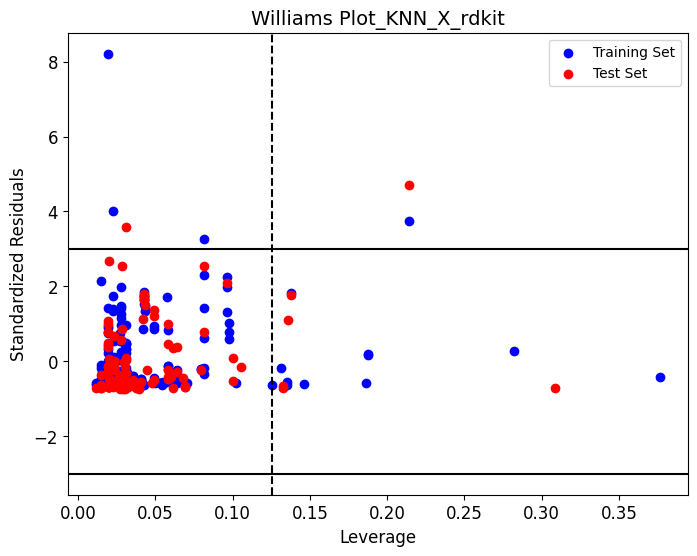

AD Training: 95.32%
AD Test: 96.55%


========== Applicability Domain: Model: KNN, Feature Type: X_ECFP6 ==========


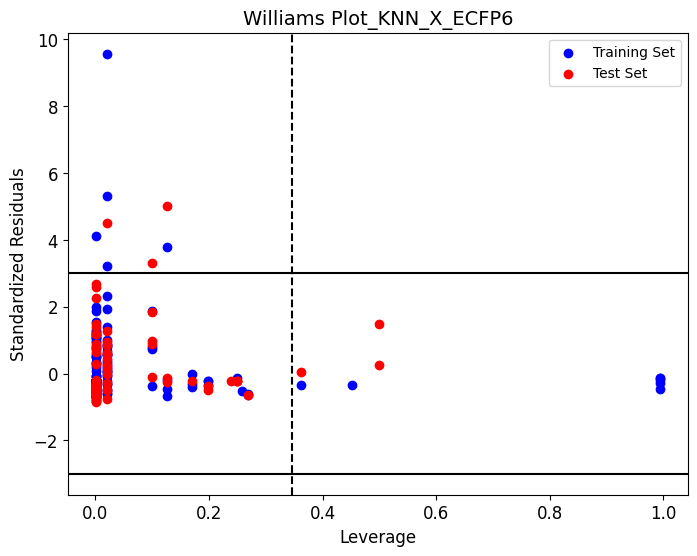

AD Training: 90.64%
AD Test: 87.93%


========== Applicability Domain: Model: KNN, Feature Type: X_FCFP6 ==========


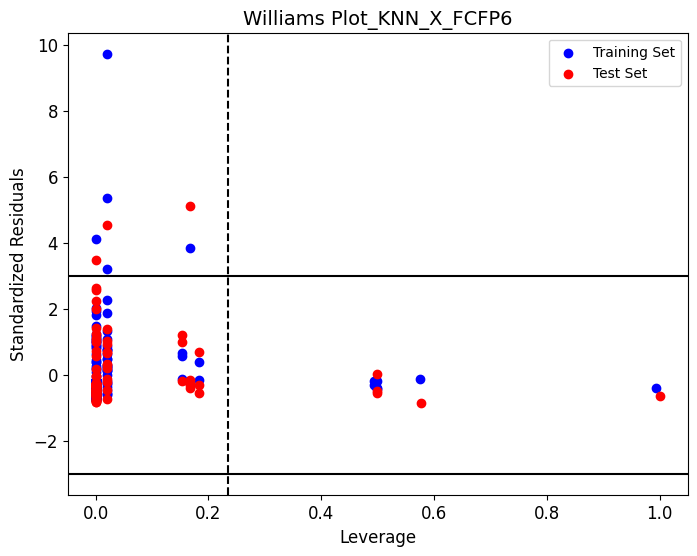

AD Training: 92.77%
AD Test: 84.48%


========== Applicability Domain: Model: KNN, Feature Type: X_MACCS ==========


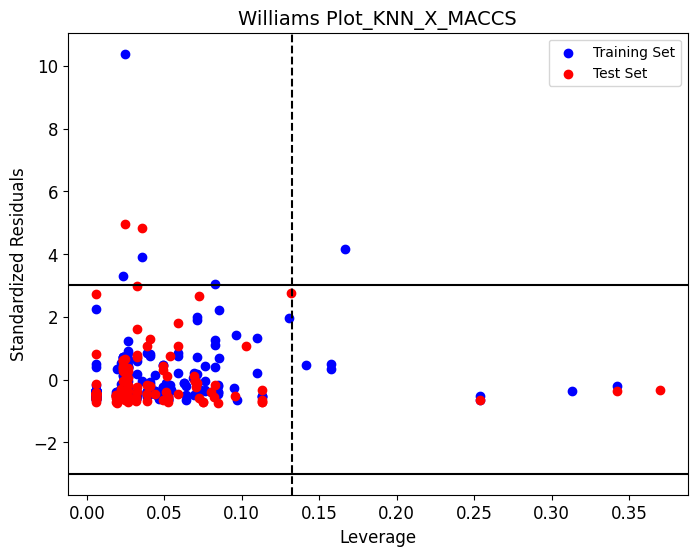

AD Training: 94.89%
AD Test: 95.69%


========== Applicability Domain: Model: KNN, Feature Type: X_All_descrs ==========


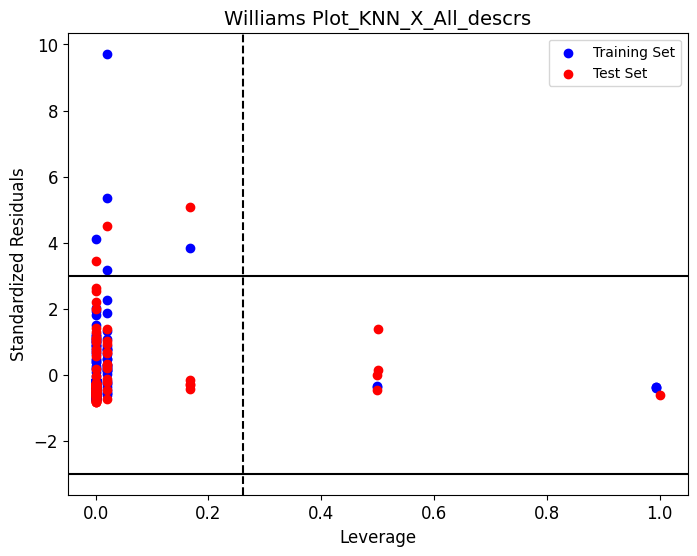

AD Training: 95.74%
AD Test: 89.66%


========== Applicability Domain: Model: RF, Feature Type: X_rdkit ==========


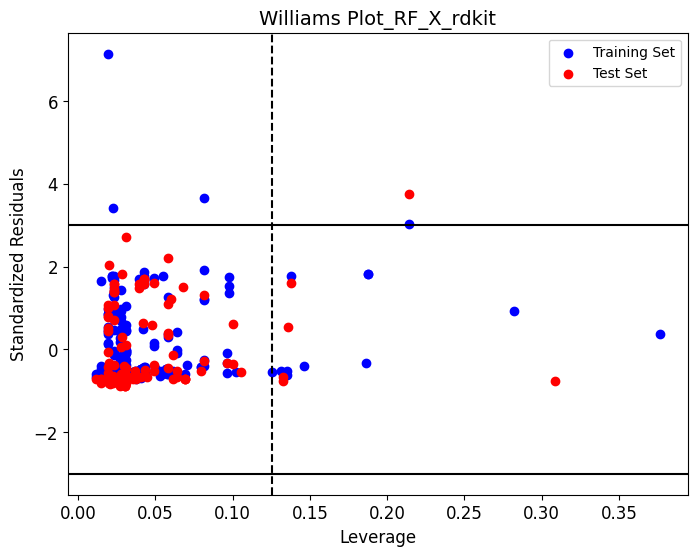

AD Training: 95.32%
AD Test: 97.41%


========== Applicability Domain: Model: RF, Feature Type: X_ECFP6 ==========


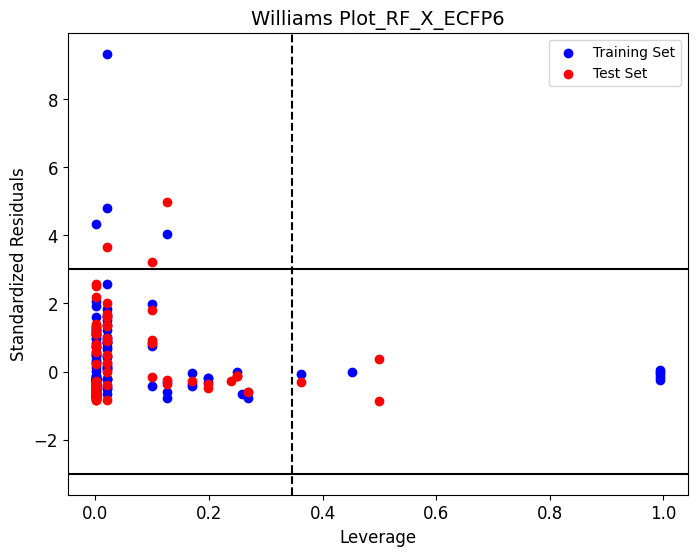

AD Training: 91.06%
AD Test: 87.93%


========== Applicability Domain: Model: RF, Feature Type: X_FCFP6 ==========


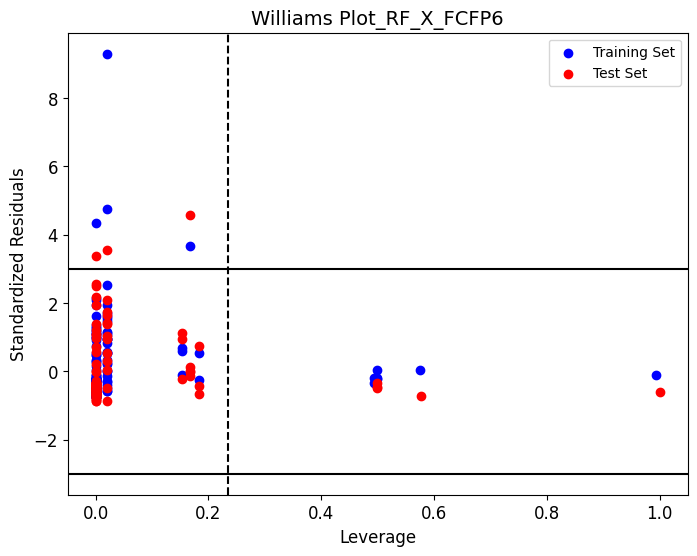

AD Training: 93.19%
AD Test: 84.48%


========== Applicability Domain: Model: RF, Feature Type: X_MACCS ==========


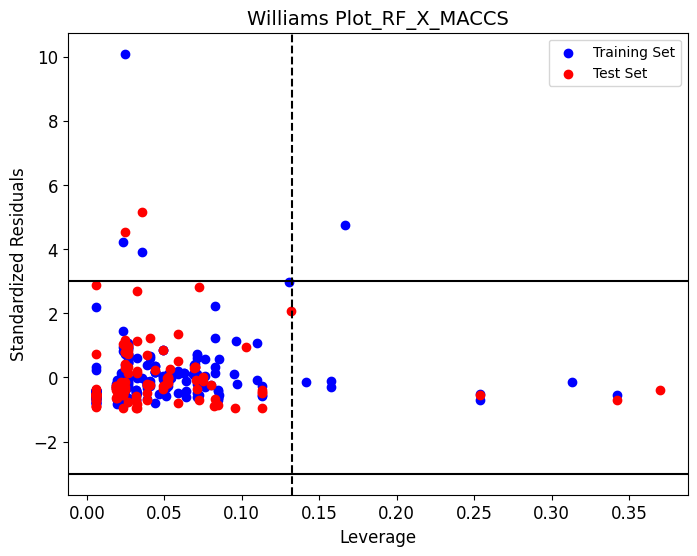

AD Training: 95.32%
AD Test: 95.69%


========== Applicability Domain: Model: RF, Feature Type: X_All_descrs ==========


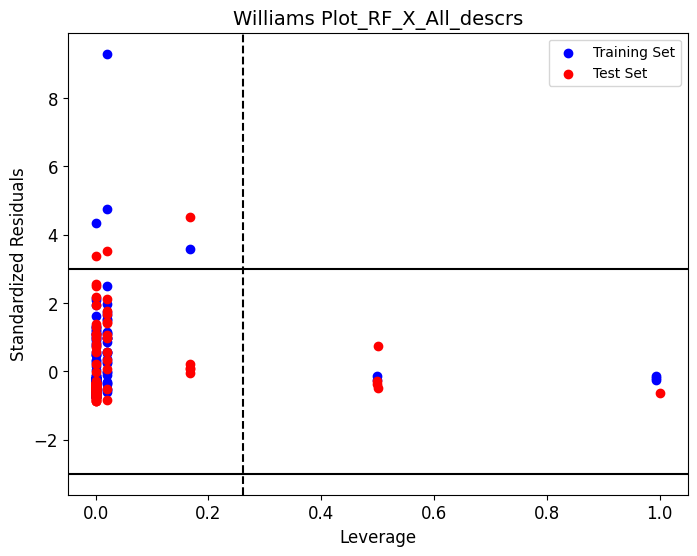

AD Training: 96.17%
AD Test: 89.66%


========== Applicability Domain: Model: SVR, Feature Type: X_rdkit ==========


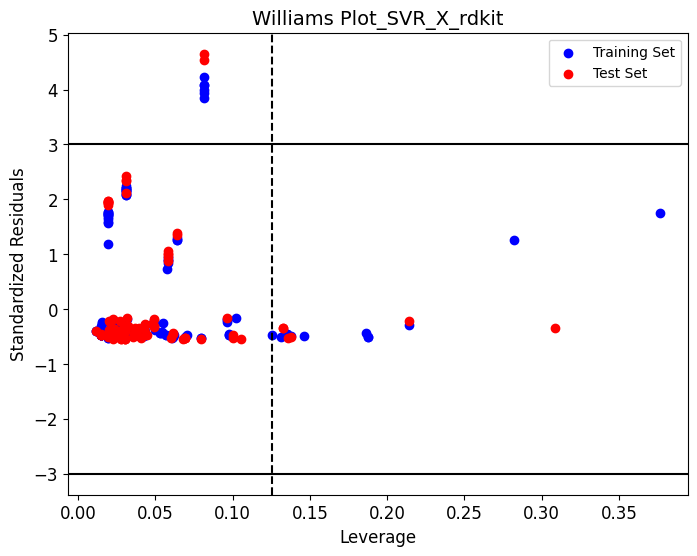

AD Training: 94.04%
AD Test: 95.69%


========== Applicability Domain: Model: SVR, Feature Type: X_ECFP6 ==========


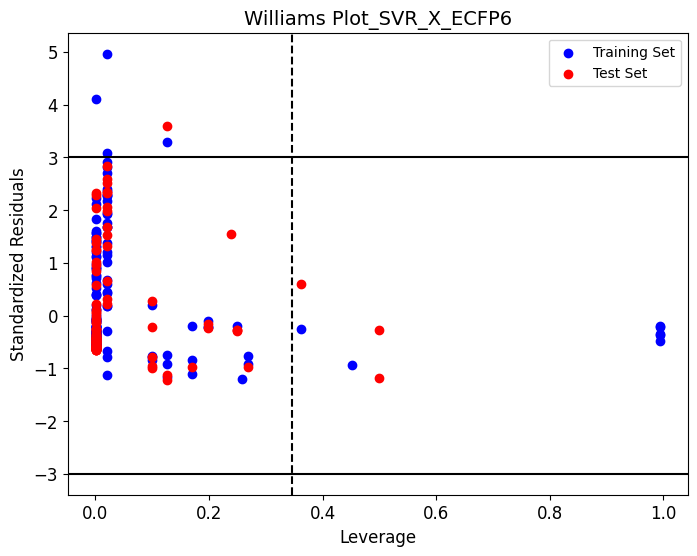

AD Training: 91.06%
AD Test: 89.66%


========== Applicability Domain: Model: SVR, Feature Type: X_FCFP6 ==========


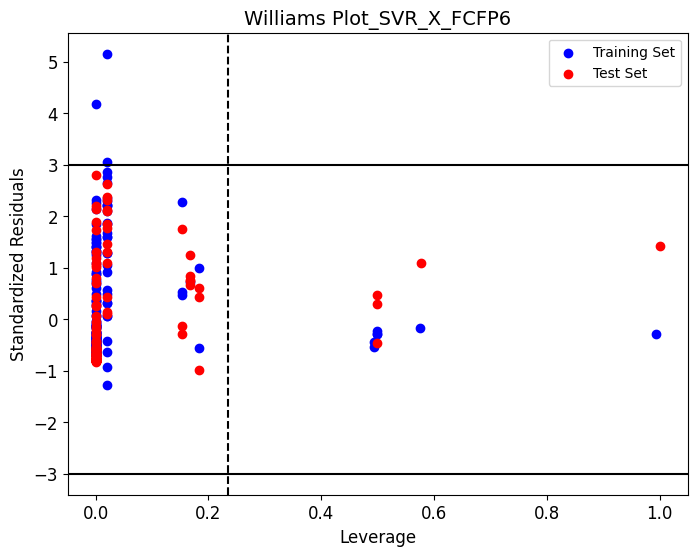

AD Training: 93.19%
AD Test: 86.21%


========== Applicability Domain: Model: SVR, Feature Type: X_MACCS ==========


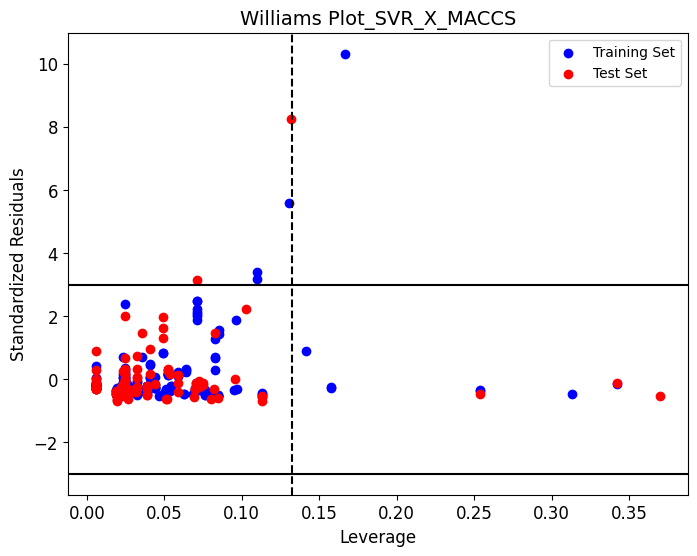

AD Training: 95.32%
AD Test: 95.69%


========== Applicability Domain: Model: SVR, Feature Type: X_All_descrs ==========


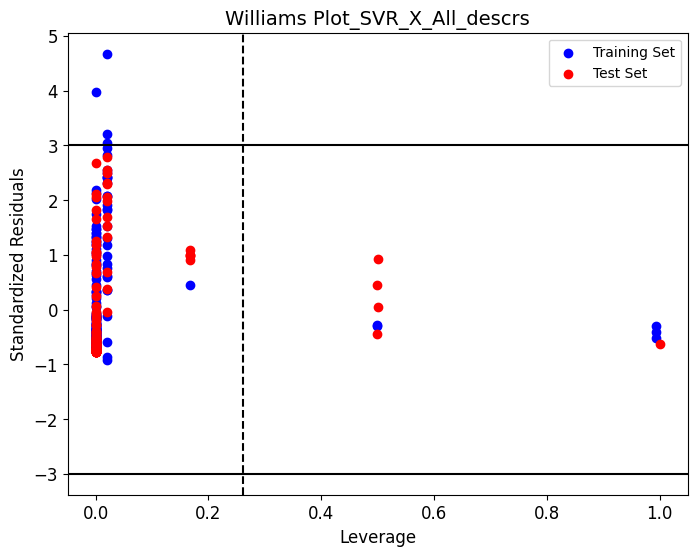

AD Training: 95.74%
AD Test: 91.38%




In [34]:
from sklearn.preprocessing import StandardScaler

# Define the applicability domain function
def hat_matrix(X, random_seed=None):
    np.random.seed(random_seed)  # set random state for reproducibility

    xtx = np.dot(X.T, X)
    np.fill_diagonal(xtx, np.diagonal(xtx) + np.random.uniform(0.001, 0.002, size=len(xtx)))
    ixtx = np.linalg.pinv(xtx)
    return np.dot(np.dot(X, ixtx), X.T)

def eval_ad(X_train, X_test, y_train, y_test, model):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    H_train = hat_matrix(np.vstack((X_train, X_test)), random_seed=2)  # set random state for reproducibility

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    residual_train = np.abs(y_train - y_pred_train)
    residual_test = np.abs(y_test - y_pred_test)
    s_residual_train = (residual_train - np.mean(residual_train)) / np.std(residual_train)
    s_residual_test = (residual_test - np.mean(residual_test)) / np.std(residual_test)

    leverage_train = np.diag(H_train)[:X_train.shape[0]]
    leverage_test = np.diag(H_train)[X_train.shape[0]:]

    p = X_train.shape[1] + 1  # features
    n = X_train.shape[0] + X_test.shape[0]  # total compounds
    h_star = (3 * p) / n

    AD_train = 100 * np.sum((leverage_train < h_star) & (np.abs(s_residual_train) < 3)) / len(leverage_train)
    AD_test = 100 * np.sum((leverage_test < h_star) & (np.abs(s_residual_test) < 3)) / len(leverage_test)

    return AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test

def plot_williams(leverage_train, s_residual_train, leverage_test, s_residual_test, model_name, feature_type):
    plt.figure(figsize=(8, 6))
    plt.scatter(leverage_train, s_residual_train, c='blue', label='Training Set')
    plt.scatter(leverage_test, s_residual_test, c='red', label='Test Set')
    plt.axhline(y=np.mean(s_residual_train) + 3 * np.std(s_residual_train), color='black', linestyle='-')
    plt.axhline(y=np.mean(s_residual_train) - 3 * np.std(s_residual_train), color='black', linestyle='-')
    plt.axvline(x=np.mean(leverage_train) + 2 * np.std(leverage_train), color='black', linestyle='--')
    plt.xlabel('Leverage', fontsize=12)
    plt.ylabel('Standardized Residuals', fontsize=12)
    plt.title(f'Williams Plot_{model_name}_{feature_type}', fontsize=14)
    plt.legend()
    # Increase font size for x-axis and y-axis tick labels
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

for model_name, features_dict in selected_features_dict.items():
    for feature_type, selected_features in features_dict.items():
        print(f"========== Applicability Domain: Model: {model_name}, Feature Type: {feature_type} ==========")

        # Get the correct feature matrix X based on feature_type
        if feature_type == 'X_rdkit':
            X_current = X_rdkit
        elif feature_type == 'X_ECFP6':
            X_current = X_ECFP6
        elif feature_type == 'X_FCFP6':
            X_current = X_FCFP6
        elif feature_type == 'X_MACCS':
            X_current = X_MACCS
        elif feature_type == 'X_All_descrs':
            X_current = X_All_descrs

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.33, random_state=9)

        # Create selector and transform data
        selector = SelectKBest(score_func=f_regression, k=k_best_features)
        selector.fit(X_train, y_train)
        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)

        # Get the best model for current combination
        best_model = best_model_dict[model_name][feature_type]

        # Evaluate the applicability domain
        AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test = eval_ad(
            X_train_selected, X_test_selected, y_train, y_test, best_model)

        # Plot the Williams plot
        plot_williams(leverage_train, s_residual_train, leverage_test, s_residual_test,
                     model_name, feature_type)

        print(f"AD Training: {AD_train:.2f}%")
        print(f"AD Test: {AD_test:.2f}%")
        print("\n")

# Correlation for KNN, RF, or SVR Models with Feature Selection

========== Correlation Plot: Model: KNN, Feature Type: X_rdkit ==========


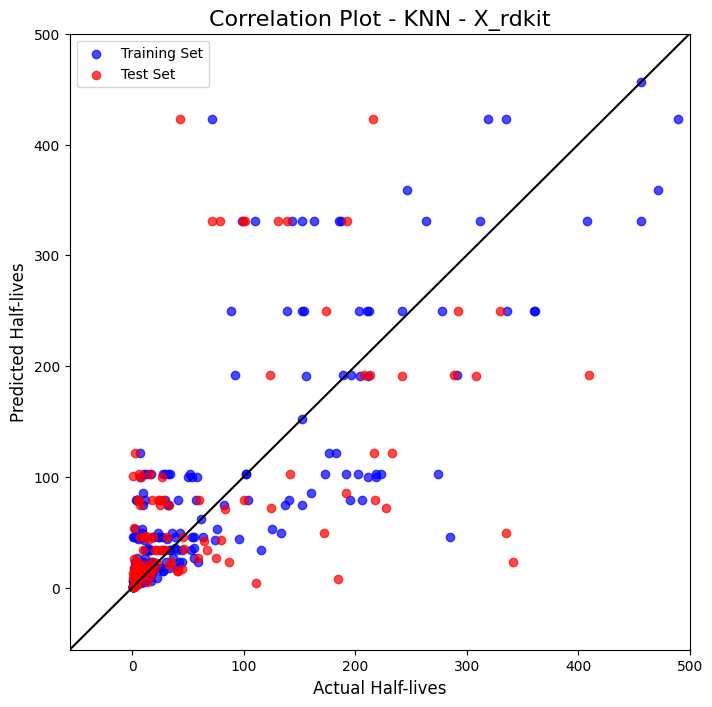



========== Correlation Plot: Model: KNN, Feature Type: X_ECFP6 ==========


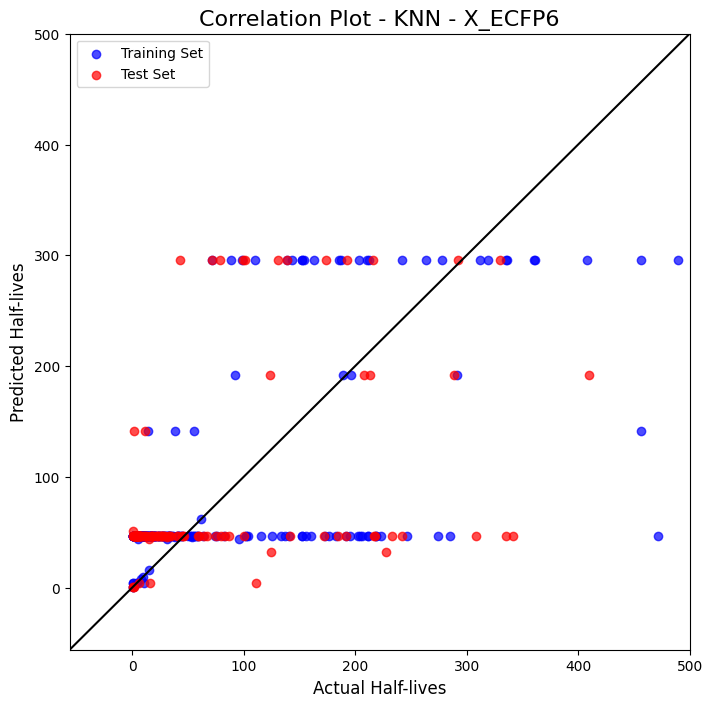



========== Correlation Plot: Model: KNN, Feature Type: X_FCFP6 ==========


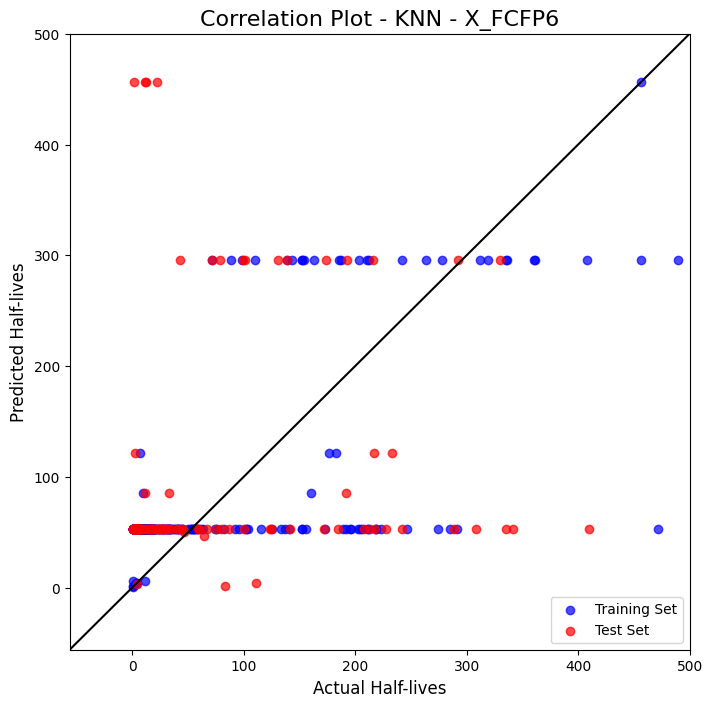



========== Correlation Plot: Model: KNN, Feature Type: X_MACCS ==========


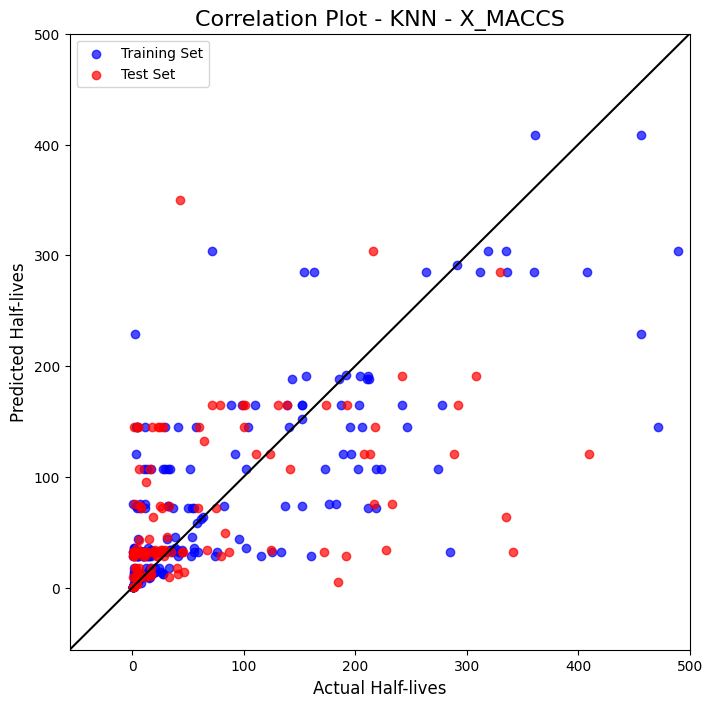



========== Correlation Plot: Model: KNN, Feature Type: X_All_descrs ==========


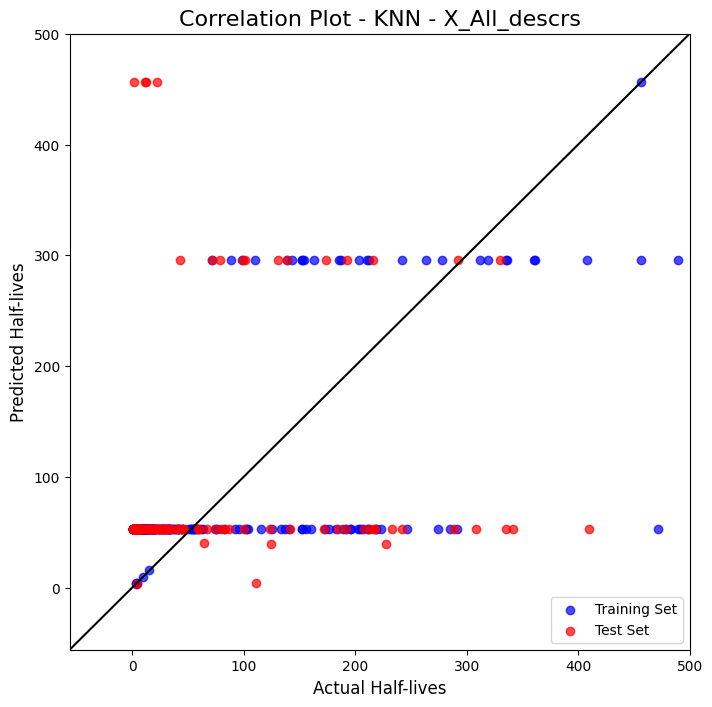



========== Correlation Plot: Model: RF, Feature Type: X_rdkit ==========


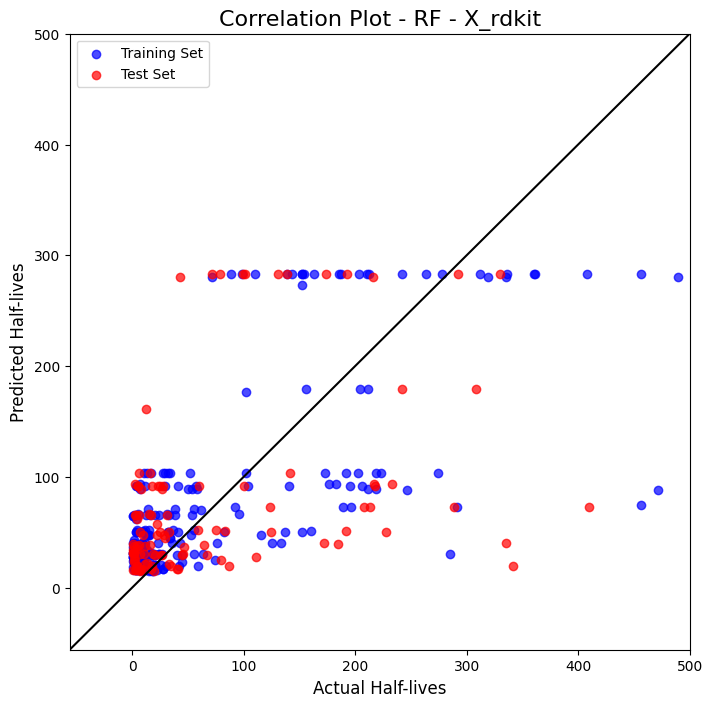



========== Correlation Plot: Model: RF, Feature Type: X_ECFP6 ==========


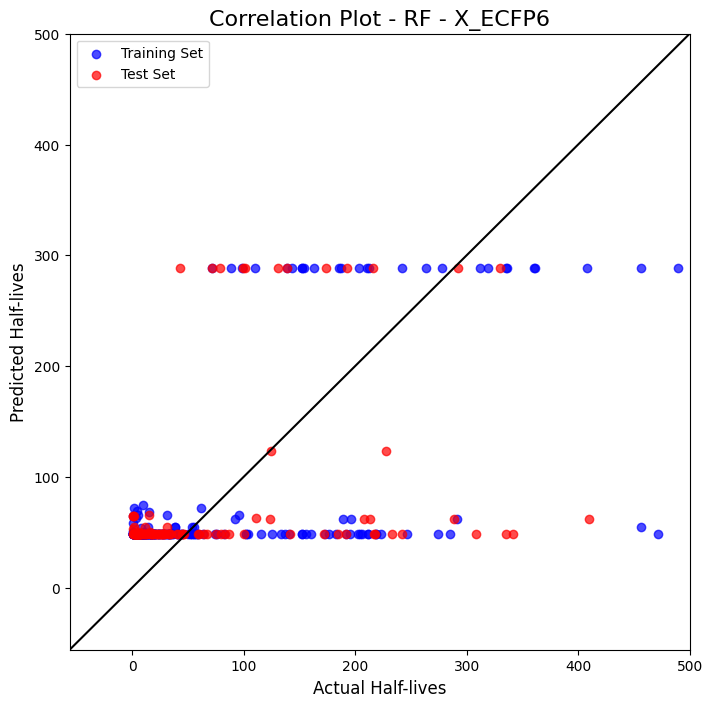



========== Correlation Plot: Model: RF, Feature Type: X_FCFP6 ==========


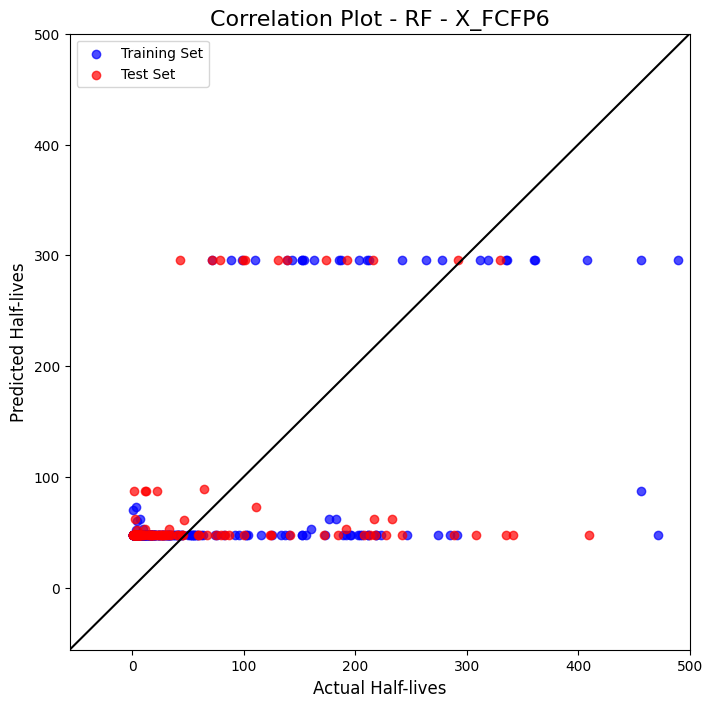



========== Correlation Plot: Model: RF, Feature Type: X_MACCS ==========


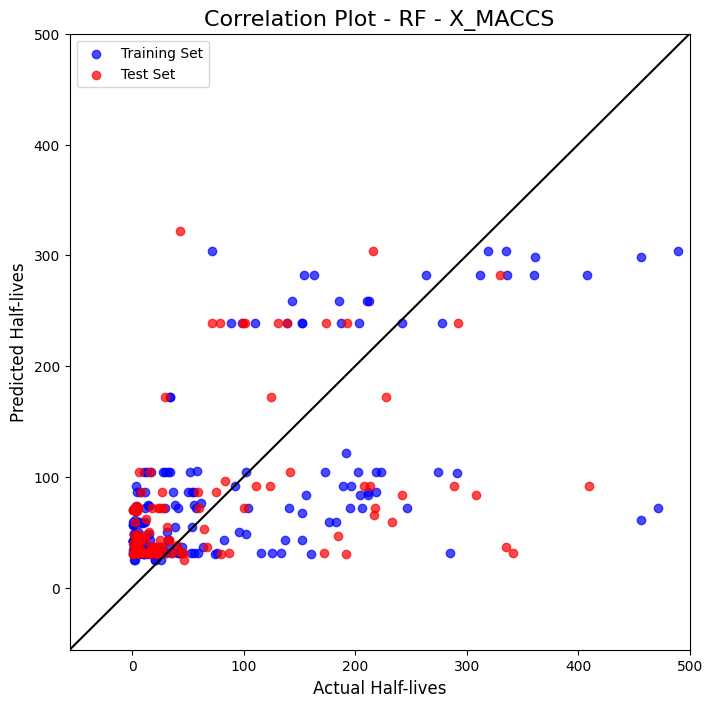



========== Correlation Plot: Model: RF, Feature Type: X_All_descrs ==========


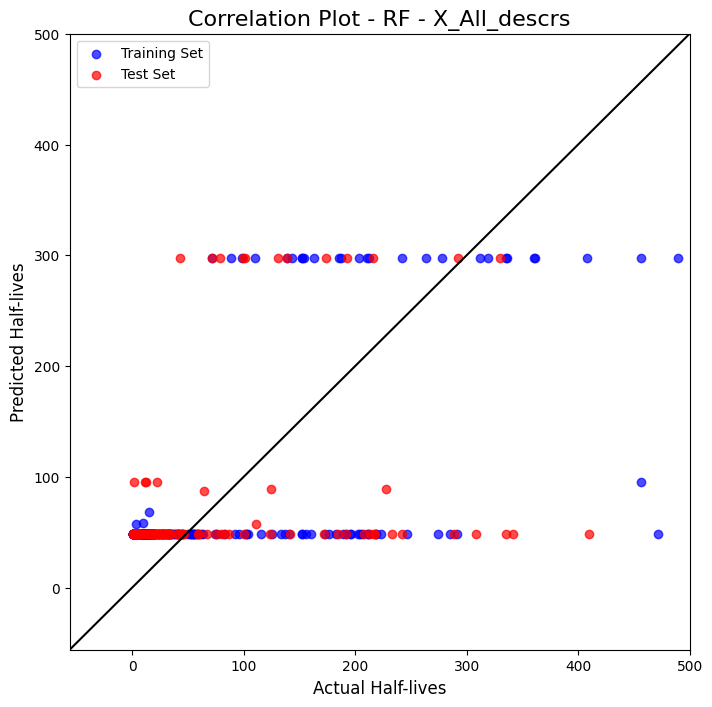



========== Correlation Plot: Model: SVR, Feature Type: X_rdkit ==========


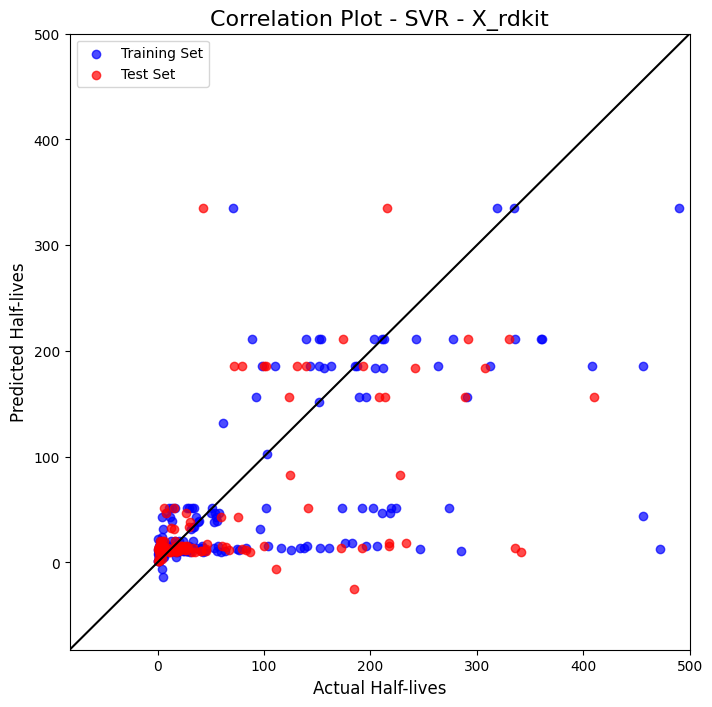



========== Correlation Plot: Model: SVR, Feature Type: X_ECFP6 ==========


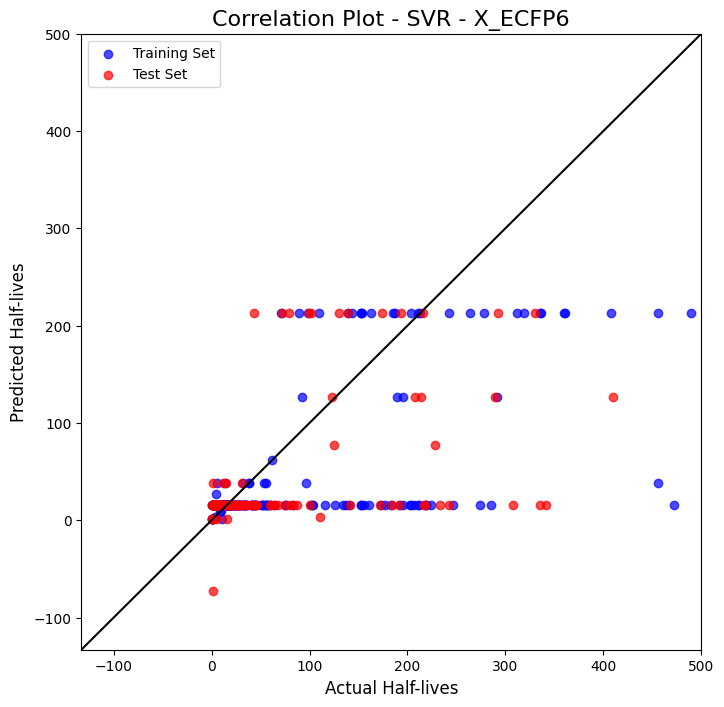



========== Correlation Plot: Model: SVR, Feature Type: X_FCFP6 ==========


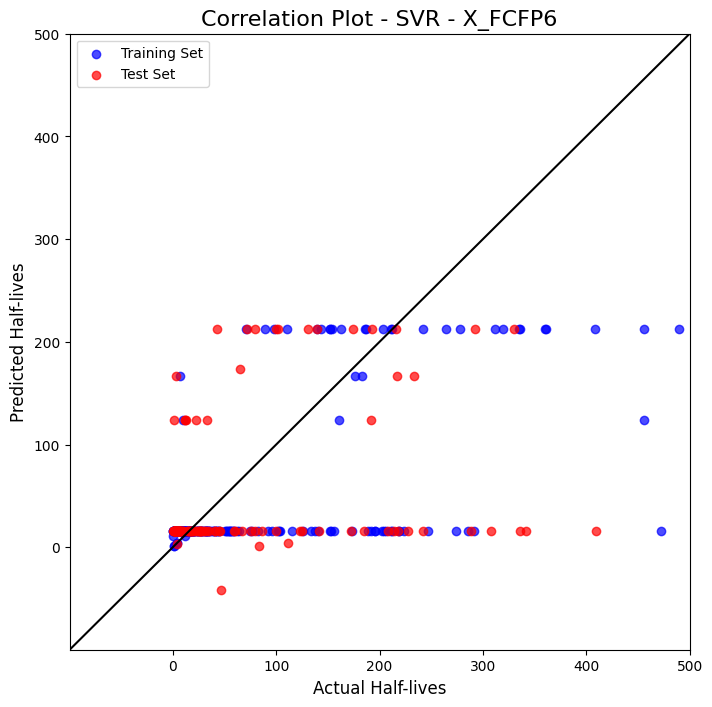



========== Correlation Plot: Model: SVR, Feature Type: X_MACCS ==========


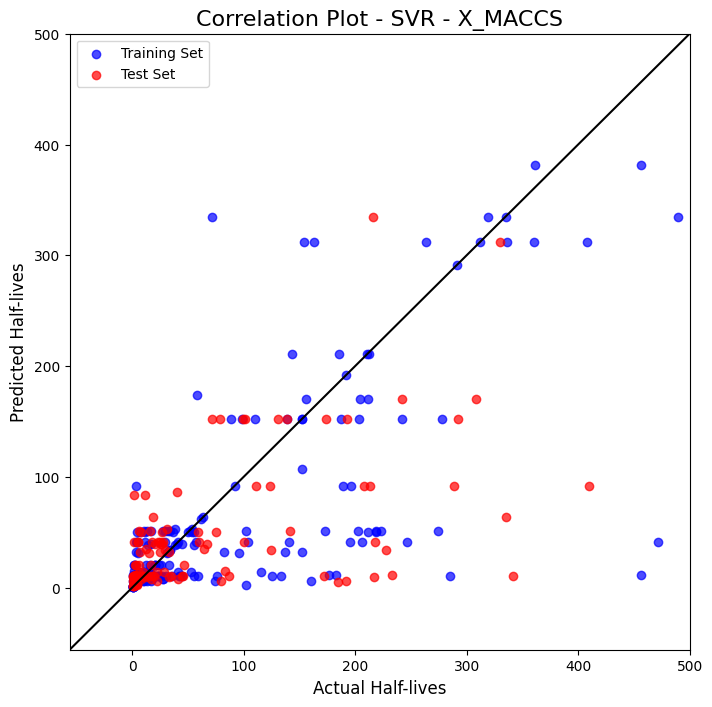



========== Correlation Plot: Model: SVR, Feature Type: X_All_descrs ==========


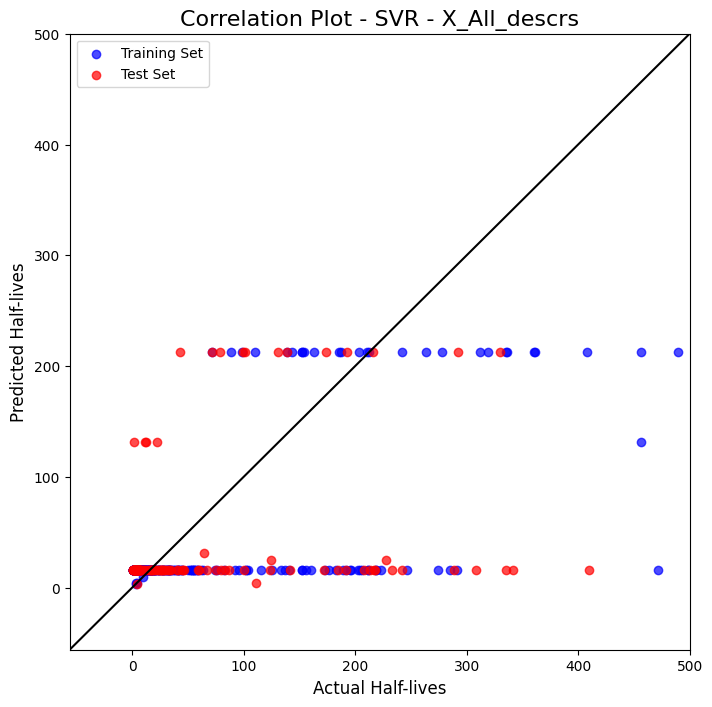

In [35]:
# Define plotting markers (simplified for single species)
markers = ['o']
feature_types_Cor = ['X_rdkit', 'X_ECFP6', 'X_FCFP6', 'X_MACCS', 'X_All_descrs']

def plot_correlation(X, y_train, y_hat_train, y_test, y_hat_test, model_name, feature_type):
    plt.figure(figsize=(8, 8))  # Square plot

    # Plot training set data points
    plt.scatter(y_train, y_hat_train, color='blue', marker='o',
               label='Training Set', alpha=0.7)

    # Plot test set data points
    plt.scatter(y_test, y_hat_test, color='red', marker='o',
               label='Test Set', alpha=0.7)

    # Calculate plot boundaries
    all_values = np.concatenate([y_train, y_hat_train, y_test, y_hat_test])
    data_range = max(all_values) - min(all_values)
    min_val = min(all_values) - 0.05 * data_range
    max_val = 500

    # Add y=x line
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='black')

    plt.title(f'Correlation Plot - {model_name} - {feature_type}', fontsize=16)
    plt.xlabel('Actual Half-lives', fontsize=12)
    plt.ylabel('Predicted Half-lives', fontsize=12)

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    plt.legend()
    plt.show()

# Generate correlation plots for each model and feature type
for model_name, features_dict in selected_features_dict.items():
    for feature_type in feature_types_Cor:
        if feature_type in features_dict:
            selected_features = features_dict[feature_type]
            print(f"========== Correlation Plot: Model: {model_name}, Feature Type: {feature_type} ==========")

            # Get the best model
            best_model = best_model_dict[model_name][feature_type]

            # Select appropriate feature matrix
            X = globals()[feature_type]

            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9)

            # Select features
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            # Make predictions
            y_hat_train = best_model.predict(X_train_selected)
            y_hat_test = best_model.predict(X_test_selected)

            # Plot correlations
            plot_correlation(X, y_train, y_hat_train, y_test, y_hat_test, model_name, feature_type)
            print("\n")

# Deep Neural Network Model with Keras


In [36]:
!pip install -q keras-tuner
import keras_tuner as kt
from tensorflow import keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


In [37]:
# ── Section 1: Imports, Seeds & Data ───────────────────────────
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import kerastuner as kt

# Fix seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

descriptor_sets = {
    'RDKit' : X_rdkit,
    'ECFP6' : X_ECFP6,
    'FCFP6' : X_FCFP6,
    'MACCS' : X_MACCS,
    'All'   : X_All_descrs
}


In [38]:
# ── Section 2: Model Builder & Bayesian Tuning ────────────────
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

def build_model(hp, input_dim):
    model = Sequential()

    # — Input layer with L2, BatchNorm, Dropout —
    model.add(Dense(
        units=hp.Int('units_in',   64, 256, step=32, default=128),
        activation=hp.Choice('act_in', ['relu','tanh'], default='relu'),
        kernel_regularizer=l2(hp.Float('l2_in', 1e-5, 1e-3, sampling='LOG', default=1e-4)),
        input_shape=(input_dim,)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('drop_in', 0.1, 0.5, step=0.1, default=0.2)))

    # — 1–2 hidden layers —
    for i in range(hp.Int('n_hidden', 1, 2, default=1)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', 64, 256, step=32, default=128),
            activation=hp.Choice(f'act_{i}', ['relu','tanh'], default='relu'),
            kernel_regularizer=l2(hp.Float(f'l2_{i}', 1e-5, 1e-3, sampling='LOG', default=1e-4))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'drop_{i}', 0.1, 0.5, step=0.1, default=0.2)))

    # — Output layer —
    model.add(Dense(1, activation='linear'))

    # — Optimizer choice —
    if hp.Choice('opt', ['adam','sgd'], default='adam') == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('lr_adam', [1e-3,1e-4], default=1e-3))
    else:
        optimizer = SGD(
            learning_rate=hp.Choice('lr_sgd', [1e-3,1e-4], default=1e-3),
            momentum=0.9, nesterov=True
        )

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

# Loop to tune each descriptor set
for name, X_df in descriptor_sets.items():
    print(f"\n--- Tuning on {name} descriptors ---")

    # Convert DataFrame to NumPy
    X = X_df.astype(np.float32).values
    y_arr = y.values.astype(np.float32)        # <— convert Series to 1D numpy array

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_arr, test_size=0.33, random_state=2
    )

    tuner = kt.BayesianOptimization(
        hypermodel=lambda hp: build_model(hp, input_dim=X_train.shape[1]),
        objective='val_mse',
        max_trials=20,
        executions_per_trial=3,
        overwrite=True,
        directory='tuner_dir',
        project_name='dnn_qsar_method1'
)

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    tuner.search(
        X_train, y_train,
        validation_split=0.2,    # ← hold out 20% of train for hyperparam tuning
        epochs=200,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
)

    # retrieve best model & HP
    best_hp    = tuner.get_best_hyperparameters()[0]
    best_model = tuner.get_best_models()[0]

    # save out with a consistent .keras extension
    fname = f"best_model_{name}.keras"
    best_model.save(fname)
    print(f"→ Saved {name} model to {fname}")


Trial 20 Complete [00h 00m 38s]
val_mse: 13200.732096354166

Best val_mse So Far: 5309.052083333333
Total elapsed time: 00h 14m 26s
→ Saved All model to best_model_All.keras


In [39]:
# ── Section 3: Load, Evaluate & Simple Metrics ─────────────────────────

for name in descriptor_sets:
    print(f"\n=== Eval {name} ===")
    fname = f"best_model_{name}.keras"
    model = load_model(fname)   # no custom_objects needed

    # get original split again
    X = descriptor_sets[name].astype(np.float32).values
    y_arr = y.values.astype(np.float32)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_arr, test_size=0.33, random_state=2
    )

    # preds
    y_pred_train = model.predict(X_train).reshape(-1)
    y_pred_test  = model.predict(X_test).reshape(-1)

    # metrics
    r2_tr   = r2_score(y_train, y_pred_train)
    r2_te   = r2_score(y_test,  y_pred_test)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_te = np.sqrt(mean_squared_error(y_test,  y_pred_test))

    print(f"Train → R²: {r2_tr:.3f}, RMSE: {rmse_tr:.3f}")
    print(f"Test  → R²: {r2_te:.3f}, RMSE: {rmse_te:.3f}")



=== Eval RDKit ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train → R²: 0.499, RMSE: 92.172
Test  → R²: 0.485, RMSE: 90.185

=== Eval ECFP6 ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train → R²: 0.369, RMSE: 103.398
Test  → R²: 0.298, RMSE: 105.327

=== Eval FCFP6 ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train → R²: 0.334, RMSE: 106.218
Test  → R²: 0.223, RMSE: 110.798

=== Eval MACCS ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train → R²: 0.349, RMSE: 105.032
Test  → R²: 0.317, RMSE: 103.906

=== Eval All ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train → R²: 0.442, RMSE: 97.273
Test  → R²: 0.448, RMSE: 93.444


In [40]:
# ── Section 4: 5-Fold CV on Training Set (fixed) ─────────────────────────

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import numpy as np

# ── Section 4: 5-Fold CV on Training Set (fixed) ─────────────────────────

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd # Assuming pandas is used for df

# Assume descriptor_sets and y are defined elsewhere

for name, df in descriptor_sets.items():
    print(f"\n*** 5-Fold CV for {name} ***")

    # --- Debug: Check initial DataFrame for NaNs ---
    feature_cols = [c for c in df.columns if not c.startswith('y_')]
    print(f"Checking NaNs in source DataFrame columns for {name}:")
    print(df[feature_cols].isnull().sum())

    # 2) Extract ONLY the descriptor columns
    X_full = df[feature_cols].astype(np.float32).values
    y_full = y.values.astype(np.float32) # Make sure 'y' corresponds correctly

    # --- Debug: Check for NaNs after conversion ---
    if np.any(np.isnan(X_full)):
        print(f"NaNs found in X_full for {name} AFTER conversion!")
    if np.any(np.isnan(y_full)):
        print(f"NaNs found in y_full for {name} AFTER conversion!")

    # 3) Single train split (CV is done on this training portion)
    X_train, _, y_train, _ = train_test_split(
        X_full, y_full, test_size=0.33, random_state=2
    )

    # 4) 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=2)
    r2_scores, rmse_scores = [], []
    fold_counter = 0 # For better print messages

    for tr_idx, te_idx in kf.split(X_train):
        fold_counter += 1
        print(f"--- Processing Fold {fold_counter} for {name} ---")
        X_tr, X_te = X_train[tr_idx], X_train[te_idx]
        y_tr, y_te = y_train[tr_idx], y_train[te_idx]

        # *** FIX: Load a fresh model instance for each fold ***
        model = load_model(f"best_model_{name}.keras")

        # Retrain on this fold's training data
        model.fit(X_tr, y_tr, epochs=200, batch_size=64, verbose=0)

        # Make predictions on this fold's test data
        preds = model.predict(X_te).reshape(-1)

        # --- Debug: Check for NaNs before metric calculation ---
        nan_in_preds = np.any(np.isnan(preds))
        nan_in_y_te = np.any(np.isnan(y_te))

        if nan_in_preds:
            print(f"Fold {fold_counter}: NaNs FOUND in predictions!")
        if nan_in_y_te:
            print(f"Fold {fold_counter}: NaNs FOUND in y_te!")

        # Calculate metrics only if inputs are finite
        if not nan_in_preds and not nan_in_y_te:
            r2_scores.append(r2_score(y_te, preds))
            rmse_scores.append(sqrt(mean_squared_error(y_te, preds)))
        else:
            print(f"Fold {fold_counter}: Skipping metrics calculation due to NaNs.")
            # Optionally append NaN or skip appending to track problematic folds
            r2_scores.append(np.nan)
            rmse_scores.append(np.nan)

    # Calculate average scores, ignoring NaNs if any occurred
    mean_r2 = np.nanmean(r2_scores)
    std_r2 = np.nanstd(r2_scores)
    mean_rmse = np.nanmean(rmse_scores)
    std_rmse = np.nanstd(rmse_scores)

    print(f"\nResults for {name}:")
    print(f"R²:   {mean_r2:.3f} ± {std_r2:.3f}")
    print(f"RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")




*** 5-Fold CV for RDKit ***
Checking NaNs in source DataFrame columns for RDKit:
Route_Bronchial fluid                 0
Route_Cutaneous (topical)             0
Route_IV (Regional Limb Perfusion)    0
Route_Intra-Arterial                  0
Route_Intramammary                    0
                                     ..
rdkit_fr_thiazole                     0
rdkit_fr_thiocyan                     0
rdkit_fr_thiophene                    0
rdkit_fr_unbrch_alkane                0
rdkit_fr_urea                         0
Length: 233, dtype: int64
--- Processing Fold 1 for RDKit ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
--- Processing Fold 2 for RDKit ---


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
--- Processing Fold 3 for RDKit ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
--- Processing Fold 4 for RDKit ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
--- Processing Fold 5 for RDKit ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Results for RDKit:
R²:   -1.026 ± 1.997
RMSE: 148.139 ± 45.836

*** 5-Fold CV for ECFP6 ***
Checking NaNs in source DataFrame columns for ECFP6:
Route_Bronchial fluid                 0
Route_Cutaneous (topical)             0
Route_IV (Regional Limb Perfusion)    0
Route_Intra-Arterial                  0
Route_Intramammary                    0
                                     ..
ECFP6_Bit_1019                        0
ECFP6_Bit_1020                        0
ECFP6_Bit_1021                        0
ECFP6_Bit_1022                        0
ECFP6_Bit_1023                        0
Length: 1057, dtype: int64
--- Processing Fold 1 for ECFP6 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
--- Processing Fold 2 for ECFP6 ---
2/2 ━━━━━━━━━━

In [41]:
# ── 1. Define hat_matrix() and eval_ad_dnn() ─────────────────────────────────
def hat_matrix(X):
    # X: (n_samples × n_features) array
    xtx = np.dot(X.T, X)
    np.fill_diagonal(xtx, np.diagonal(xtx) + np.random.uniform(0.001, 0.002, size=xtx.shape[0]))
    ixtx = np.linalg.pinv(xtx)
    return X @ ixtx @ X.T

def eval_ad_dnn(X_train, X_test, y_train, y_test, model):
    # predictions
    y_pred_train = model.predict(X_train).reshape(-1)
    y_pred_test  = model.predict(X_test).reshape(-1)

    # true values
    y_train = np.array(y_train).reshape(-1)
    y_test  = np.array(y_test).reshape(-1)

    # standardized residuals
    resid_train = np.abs(y_train - y_pred_train)
    resid_test  = np.abs(y_test  - y_pred_test)
    s_res_train = (resid_train - resid_train.mean()) / resid_train.std()
    s_res_test  = (resid_test  - resid_train.mean()) / resid_train.std()

    # leverage—combine train+test
    X_combined = np.vstack((X_train, X_test))
    H = hat_matrix(X_combined)
    lev_train = np.diag(H)[:len(X_train)]
    lev_test  = np.diag(H)[len(X_train):]

    # threshold
    p = X_train.shape[1] + 1
    n = X_train.shape[0] + X_test.shape[0]
    h_star = (3 * p) / n

    # percent inside AD
    AD_train = 100 * np.mean((lev_train < h_star) & (np.abs(s_res_train) < 3))
    AD_test  = 100 * np.mean((lev_test  < h_star) & (np.abs(s_res_test ) < 3))

    return AD_train, AD_test, s_res_train, s_res_test, lev_train, lev_test

In [42]:
# ── 2. Correlation‐plot helper ────────────────────────────────────────────────
def plot_correlation_dnn(y_train, y_hat_train, y_test, y_hat_test, model_name, feature_type):
    plt.figure(figsize=(6,6))
    plt.scatter(y_train, y_hat_train, marker='o', alpha=0.7, label='Train')
    plt.scatter(y_test,  y_hat_test,  marker='o', alpha=0.7, label='Test')
    allvals = np.concatenate([y_train, y_hat_train, y_test, y_hat_test])
    mn, mx = allvals.min(), allvals.max()
    plt.plot([mn, mx], [mn, mx], 'k-')
    plt.title(f'Corr Plot ‐ {model_name} ‐ {feature_type}')
    plt.xlabel('Actual Half-life')
    plt.ylabel('Predicted Half-life')
    plt.legend()
    plt.show()



=== Williams Plot & AD for RDKit (PCA fallback) ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


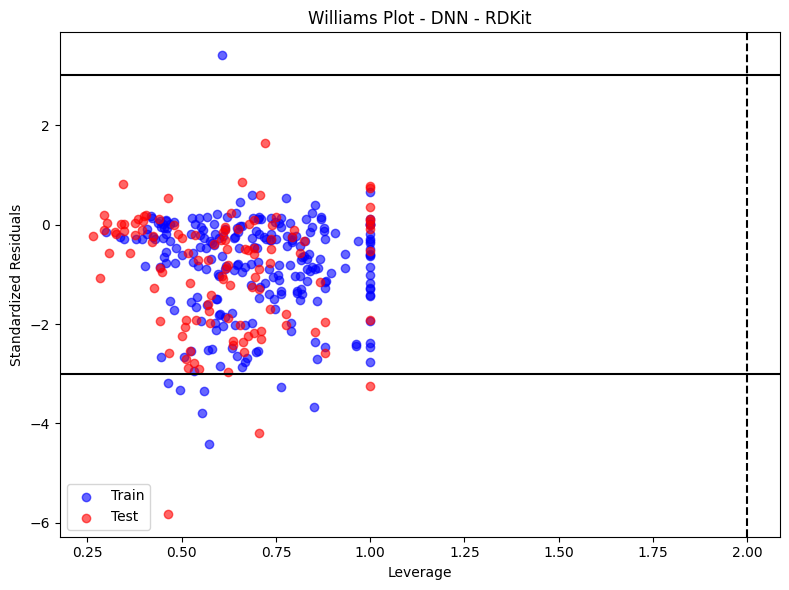

AD Training: 96.60%
AD Test:     97.41%

=== Williams Plot & AD for ECFP6 (PCA fallback) ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


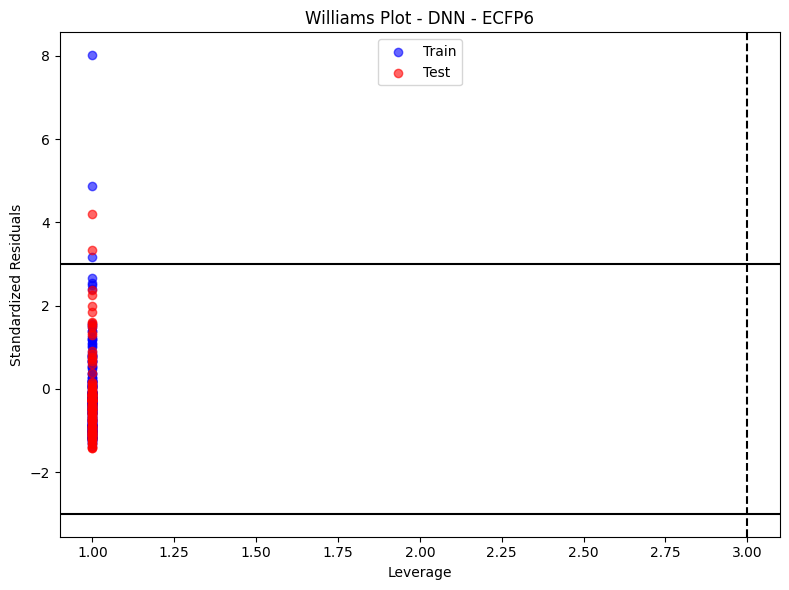

AD Training: 98.72%
AD Test:     98.28%

=== Williams Plot & AD for FCFP6 (PCA fallback) ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


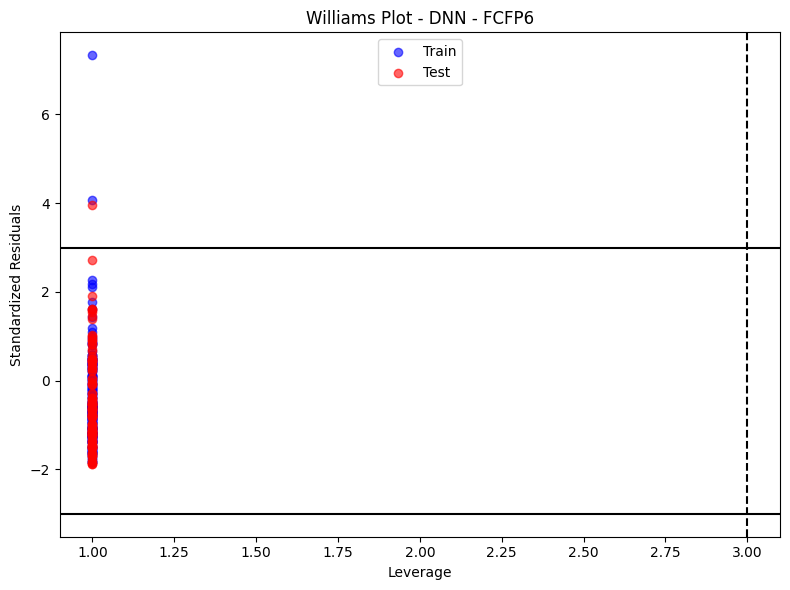

AD Training: 99.15%
AD Test:     99.14%

=== Williams Plot & AD for MACCS (PCA fallback) ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


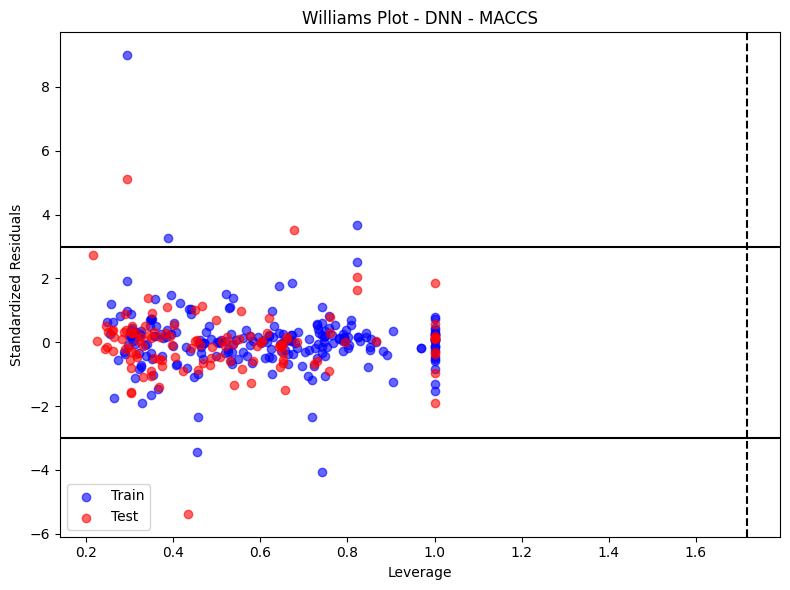

AD Training: 97.87%
AD Test:     97.41%

=== Williams Plot & AD for All (PCA fallback) ===
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


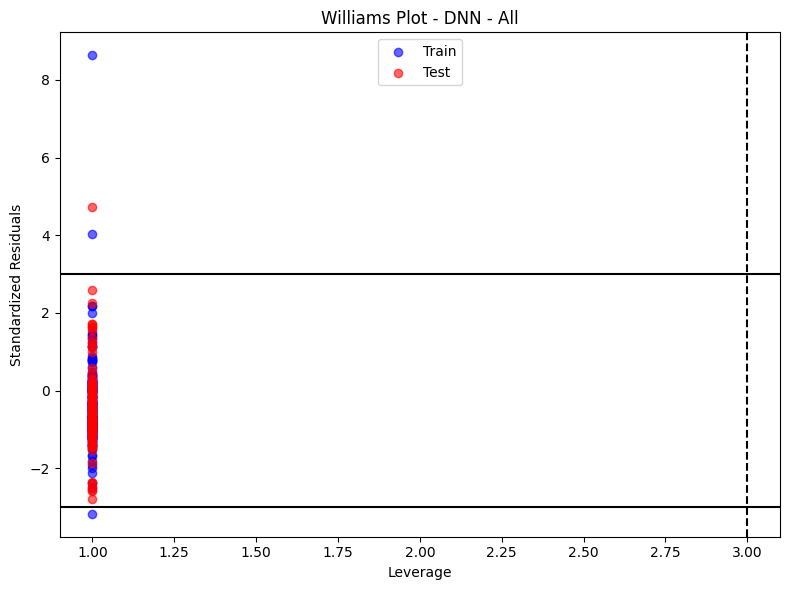

AD Training: 98.72%
AD Test:     99.14%


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

def eval_ad_pca(X_train, X_test, y_train, y_test, model):
    """
    1. Scale X
    2. If p >= n, reduce via PCA to at most n−1 components
    3. Build design matrix [1 | X_reduced]
    4. Compute leverages via SVD of the design matrix
    5. Compute standardized residuals (train σ)
    6. Compute h* = 3*(p_reduced+1)/(n_train+n_test)
    7. Return AD%, residuals, leverages, h*
    """
    # 1) scale
    scaler = StandardScaler().fit(X_train)
    X_tr = scaler.transform(X_train)
    X_te = scaler.transform(X_test)

    # 2) stack and PCA‐reduce if needed
    Xd = np.vstack((X_tr, X_te))
    n, p = Xd.shape
    if p >= n:
        pca    = PCA(n_components=n-1)
        Xd_red = pca.fit_transform(Xd)
    else:
        Xd_red = Xd

    # 3) design matrix with intercept
    X_design = np.hstack([np.ones((n,1)), Xd_red])

    # 4) leverages via SVD
    U, _, _ = np.linalg.svd(X_design, full_matrices=False)
    lever_all = np.sum(U**2, axis=1)
    lev_tr    = lever_all[:len(X_tr)]
    lev_te    = lever_all[len(X_tr):]

    # 5) residuals
    y_pred_tr = model.predict(X_tr).ravel()
    y_pred_te = model.predict(X_te).ravel()
    resid_tr  = y_train - y_pred_tr
    resid_te  = y_test  - y_pred_te
    sigma_tr  = resid_tr.std(ddof=1)
    s_res_tr  = resid_tr / sigma_tr
    s_res_te  = resid_te / sigma_tr

    # 6) leverage cutoff h*
    P_red = X_design.shape[1]       # intercept + reduced features
    h_star = 3 * P_red / n

    # 7) AD percentages
    AD_tr = 100 * np.mean((lev_tr < h_star) & (np.abs(s_res_tr) < 3))
    AD_te = 100 * np.mean((lev_te < h_star) & (np.abs(s_res_te) < 3))

    return AD_tr, AD_te, s_res_tr, s_res_te, lev_tr, lev_te, h_star

def plot_williams(lev_tr, s_res_tr, lev_te, s_res_te, h_star, title):
    plt.figure(figsize=(8,6))
    plt.scatter(lev_tr,    s_res_tr, label='Train', color='blue',  alpha=0.6)
    plt.scatter(lev_te,    s_res_te, label='Test',  color='red',   alpha=0.6)
    plt.axhline(+3, color='k'); plt.axhline(-3, color='k')
    plt.axvline(h_star, color='k', linestyle='--')
    plt.xlabel('Leverage'); plt.ylabel('Standardized Residuals')
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

# ── Run for each descriptor set ─────────────────────────────────────────
for name, df in descriptor_sets.items():
    print(f"\n=== Williams Plot & AD for {name} (PCA fallback) ===")

    # a) load model
    model = load_model(f"best_model_{name}.keras")

    # b) split data
    X = df.values.astype(np.float32)
    y_arr = y.values.astype(np.float32)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y_arr, test_size=0.33, random_state=2)

    # c) compute AD + leverages
    AD_tr, AD_te, s_tr, s_te, lev_tr, lev_te, h_star = eval_ad_pca(
        X_tr, X_te, y_tr, y_te, model
    )

    # d) plot
    plot_williams(
        lev_tr, s_tr, lev_te, s_te, h_star,
        title=f"Williams Plot ‐ DNN ‐ {name}"
    )

    # e) report
    print(f"AD Training: {AD_tr:.2f}%")
    print(f"AD Test:     {AD_te:.2f}%")
